# Comomo analysis : uSEIR quenched LLE (CCAA) - draft

version: 05-06-2020

author : JAH, JJG

In [86]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.dates as mdates
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 12

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
import os
import sys
import glob
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Thu Jun 11 16:10:40 2020


In [88]:
import ipywidgets as widgets
from ipywidgets import IntProgress
from IPython.display import display

In [89]:
import numpy as np
import pandas as pd
import matplotlib

In [90]:
import c19.data_functions_momo as momodata
import c19.momo_analysis       as c19ma

import c19.useir            as us
import c19.kfilter          as kf
import c19.useir_ana        as usa
import c19.cfit             as cfit

#import c19.momodata         as 

import scipy          as sp
import scipy.stats    as stats
import scipy.optimize as optimize

npa     = np.array
npdate  = np.datetime64
npdtime = np.timedelta64

## Data

Load Data comomo

In [91]:
path = '/Users/hernando/investigacion/bio/c19/cdata/'
dfv, dfe, dfc = momodata.comomo_from_csv(path=path)

In [92]:
dfc.head()

errors                                                         \
  Andalucia       Date Aragon Asturias Baleares Canarias Cantabria   
0       0.0 2020-03-05    0.0      0.0      0.0      0.0       0.0   
1       0.0 2020-03-06    1.0      0.0      0.0      0.0       0.0   
2       0.0 2020-03-07    0.0      0.0      0.0      0.0       0.0   
3       0.0 2020-03-08    1.0      0.0      0.0      0.0       0.0   
4       0.0 2020-03-09    1.0      0.0      0.0      0.0       0.0   

                                                ...      values                \
  Castilla La Mancha Castilla y Leon Cataluna   ...    Cataluna C. Valenciana   
0                0.0             0.0      0.0   ...         0.0           1.0   
1                0.0             0.0      0.0   ...         0.0          13.0   
2                0.0             0.0      1.0   ...         1.0           6.0   
3                0.0             0.0      0.0   ...         0.0           0.0   
4                0.0             0.0      1.0   ...         1.0           0.0   

                                                                         
  Extremadura Galicia Madrid Melilla Murcia Navarra Pais Vasco La Rioja  
0         0.0     0.0    1.0     0.0    5.0     0.0        1.0      0.0  
1         0.0     0.0   12.0     0.0    0.0     1.0        0.0      0.0  
2         0.0     1.5    9.0     0.0    2.5     0.0        1.5      6.0  
3         1.0     0.0    4.0     0.0    0.0     4.5        4.0      0.0  
4         3.0     0.0    8.0     0.0    0.0     0.0       16.0      2.0  

[5 rows x 38 columns]

## Example: Madrid and uSEIR-quenched fit

### code

In [117]:
canames = ['Madrid', 'Castilla y Leon', 'Castilla La Mancha',
           'Cataluna', 'C. Valenciana', 'Aragon',
           'Pais Vasco', 'Navarra', 'La Rioja',
           'Cantabria', 'Asturias', 'Galicia',
           'Murcia', 'Andalucia', 'Extremadura',
           'Canarias', 'Baleares']

nn = {'Madrid': 6578079, 'Castilla y Leon': 2409164, 'Castilla La Mancha': 2026807, 
      'Cataluna': 7600065, 'C. Valenciana': 4963703, 'Aragon': 1308728, 'Pais Vasco': 2199088, 
      'Navarra': 647554, 'La Rioja': 315675, 'Cantabria': 580229, 'Asturias': 1028244, 
      'Galicia': 2701743, 'Murcia': 1478509, 'Andalucia': 8384408, 'Extremadura': 1072863, 
      'Baleares': 1128908, 'Canarias': 2127685}

masks0 =  (('t0', 's1'), ('beta', 'gamma'))

def ca_cases(caname):
    dates  = dfv.Date.values
    cases  = dfv[caname].values
    ucases = dfe[caname].values
    
    if (caname == 'Galicia'):
        sel0 = dates == npdate('2020-04-29')
        sel1 = dates == npdate('2020-04-28')
        cases[sel0] = cases[sel1]
        
    return dates, cases, ucases


def ana_ca(caname, kpars = None, masks = None, fit = False):
    
    dates, cases, ucases = ca_cases(caname)
    ts                   = np.arange(len(dates))

    def kpars0(caname, tr = 2., r0 = 4., r1 = 0.8):
        n0  = nn[caname]
        phi = 0.01
        s1  = 0.6 * np.sum(cases)/(n0 * phi)
    
        kpars =  {'t0': 40.0, 'beta': r0/tr, 'gamma': r1/tr, 'tr': tr, 'ti': 5.5, 
                   'tm': 9., 'n': n0, 'phi': phi, 's1': s1}
        return kpars
    
    kpars = kpars0(caname) if kpars is None else kpars 
    masks = masks0         if masks is None else masks
    chi2 = 0.
    if (fit):
        #tbar = IntProgress(0, max = len(masks), description = caname); display(tbar)
        for imask in masks:
            #tbar.value += 1
            kpars, chi2 = usa.useirqm_chi2fit(dates, cases, kpars = kpars, kmask = imask)
            #print(caname, 'chi2 : ', chi2, ', kpars: ', kpars, ', mask ', imask)
    fmodel      = usa.useirqm_fmodel(kpars = kpars)
    usa.plot_data_model(dates, cases, fmodel)
    plt.title(caname)
    return kpars, chi2


def ana_capars(canames = canames, capars = {}, masks = masks0, fit = False, ofilename = None):
    
    ncols, nrows = 3, int(len(canames)/3)
    if (len(canames) % 3 != 0): nrows += 1

    plt.figure(figsize = (ncols * 6, nrows * 5))
    
     
    tbar = IntProgress(0, max = len(canames), description = 'fit'); display(tbar)
       
    capars2, cachi2 = {}, {}
    for i, caname in enumerate(canames):
        ax    = plt.subplot(nrows, ncols, i + 1, axisbelow=True)
        kpars = capars[caname] if caname in capars.keys() else None
        pars, chi2 = ana_ca(caname, kpars = kpars, masks = masks, fit = fit)
        tbar.value += 1
        capars2[caname] = pars
        cachi2 [caname] = chi2
        if (ofilename is not None): write_pars(caname, pars, chi2, ofilename)
        plt.title(caname)
    plt.tight_layout()
       
    return capars2, cachi2

def plot_capars(capars, cachi2, canames = None):
    
    canames = capars.keys() if canames is None else canames
    
    trs    = npa([capars[caname]['tr']    for caname in canames])
    betas  = npa([capars[caname]['beta']  for caname in canames])
    gammas = npa([capars[caname]['gamma'] for caname in canames])

    phis = npa([capars[caname]['phi'] for caname in canames])
    s1s  = npa([capars[caname]['s1']  for caname in canames])
    t0s  = npa([capars[caname]['t0']  for caname in canames])

    plt.figure(figsize = (8, 5))
    plt.plot(trs, ls = '', marker = '*', label = r'$T_R$');
    plt.plot(trs * betas, ls = '', marker = 'o', label = r'$R_0$');
    plt.plot(trs * gammas, ls = '', marker = '^', label = r'$R_1$');
    plt.legend(); plt.grid()
    plt.xticks(np.arange(len(canames)), canames, rotation = 90);
    
    plt.figure(figsize = (8, 5))
    plt.plot(100 * s1s , ls = '', marker = '^', label = r'$s_1$');
    plt.plot(100 * phis, ls = '', marker = '^', label = r'$\phi_m$');
    plt.legend(); plt.grid();
    plt.xticks(np.arange(len(canames)), canames, rotation = 90);
    
    plt.figure(figsize = (8, 5))
    plt.plot(t0s, ls = '', marker = '^', label = r'$t_0$');
    plt.legend(); plt.grid();
    plt.xticks(np.arange(len(canames)), canames, rotation = 90);
    
    chis  = npa([cachi2[caname] for caname in canames])
    
    plt.figure(figsize = (8, 5))
    plt.plot(chi2, ls = '', marker = '^', label = r'$\chi^2$');
    plt.legend(); plt.grid();
    plt.xticks(np.arange(len(canames)), canames, rotation = 90);
    return

def write_pars(caname, pars, chi2, ofilename):        
    f = open(ofilename, 'a') if ofilename is not None else None
    ss = str(caname)+', '+str(pars)+', '+str(chi2)+'\n'
    f.write(ss)
    f.close()
   
    

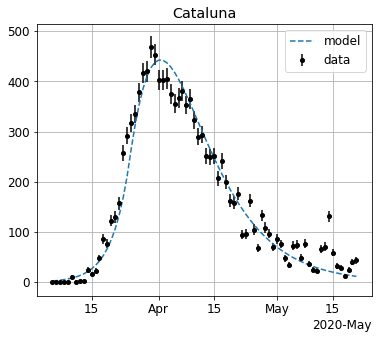

In [115]:
kpars, chi2 = ana_ca('Cataluna', fit = True)

IntProgress(value=0, description='fit', max=2)

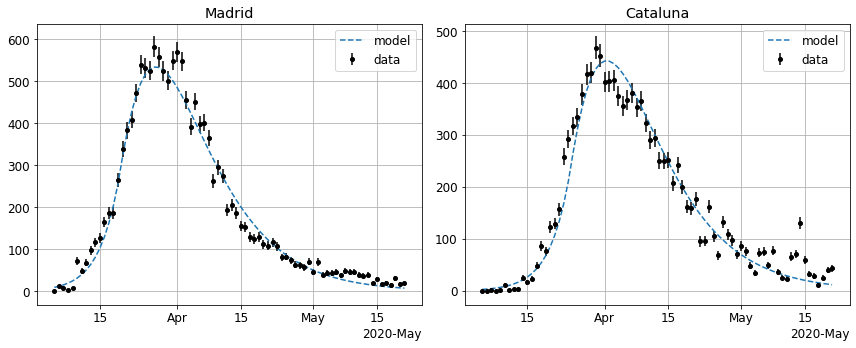

In [118]:
canames1 = ['Madrid', 'Cataluna']
capars, cachi2 = ana_capars(canames = canames1, masks = masks0, fit = True, ofilename = 'temp.txt')

IntProgress(value=0, description='fit', max=2)

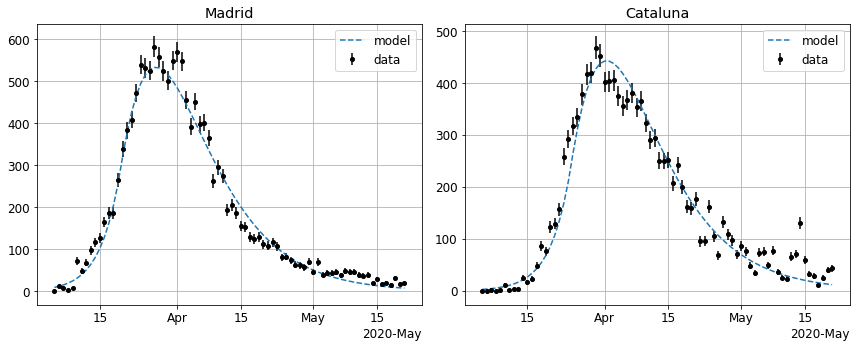

In [122]:
masks   = (('t0', 'tr'), ('s1', 'beta'), ('phi', 'gamma'))
capars, cachi2 = ana_capars(masks = masks, canames = canames1, capars = capars, fit = True, ofilename = 'temp.txt')

IntProgress(value=0, description='fit', max=2)

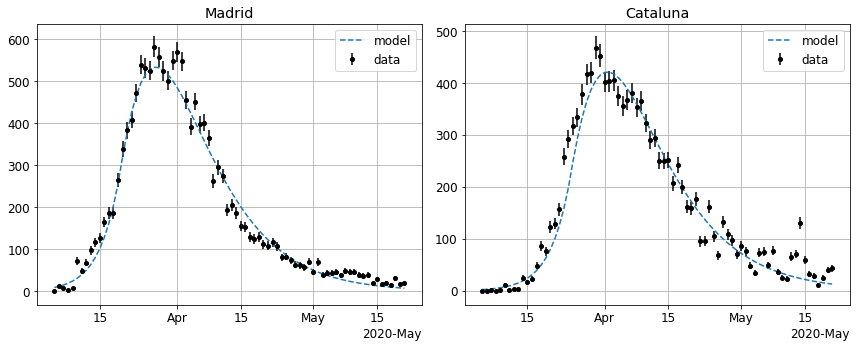

In [123]:
masks   = (('beta', 'tr', 's1'), ('gamma', 'tr', 'phi'), ('t0',))
capars, cachi2 = ana_capars(masks = masks, canames = canames1, capars = capars, 
                            fit = True, ofilename = 'temp.txt')

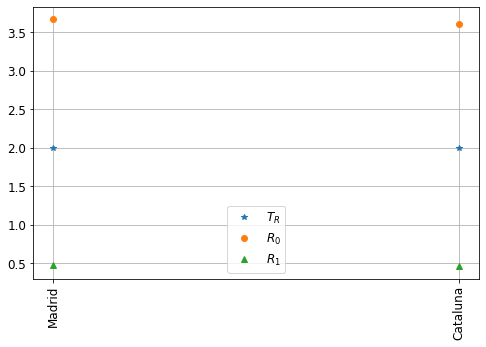

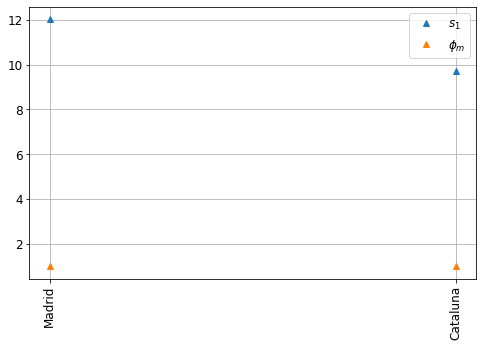

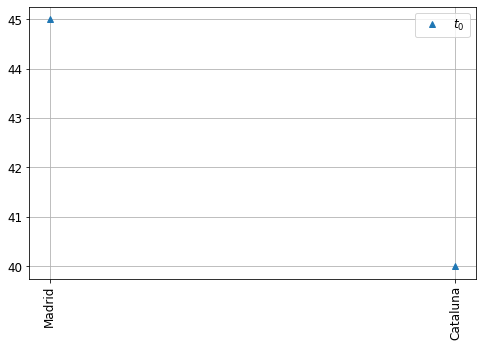

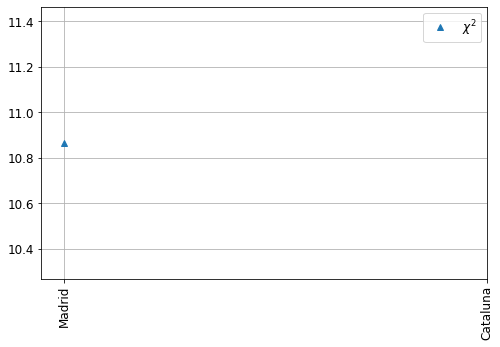

In [119]:
plot_capars(capars, cachi2, canames1)

#### - code

In [94]:
def save_ana_ca(caname, tr = 2., kpars = None, masks = None, fit = False):
    dates, cases, ucases = ca_cases(caname)
    ts                   = np.arange(len(dates))

    n0  = nn[caname]
    phi = 0.01
    s1  = 0.6 * np.sum(cases)/(n0 * phi)
    fi  = tr/2.
    
    kpars =  {'t0': 40.0, 'beta': 2./fi, 'gamma': 0.2/fi, 'tr': 2.*fi, 'ti': 5.5, 
               'tm': 10., 'n': n0, 'phi': phi, 's1': s1} if kpars is None else kpars
    #masks = (('t0', 's1'), ('beta', 'gamma'), ('t0', 'phi'), ('phi', 's1'), ('beta', 'tr'), ('gamma', 'tr'))
    #masks = 2*(('t0', 's1'), ('beta', 'gamma'), ('phi', 'tr'))
    masks = (('t0', 's1'), ('beta', 'gamma')) if masks is None else masks
    chi2 = 0.
    if (fit):
        tbar = IntProgress(0, max = len(masks))
        display(tbar)
        for imask in masks:
            tbar.value += 1
            kpars, chi2 = usa.useirqm_chi2fit(dates, cases, kpars = kpars, kmask = imask)
            print(caname, 'chi2 : ', chi2, ', kpars: ', kpars)
    fmodel      = usa.useirqm_fmodel(kpars = kpars)
    usa.plot_data_model(dates, cases, fmodel)
    plt.title(caname)
    return kpars, chi2


In [95]:
kpars, chi2 = ana_ca('Cataluna', fit = True)

NameError: name 'cases' is not defined

Cataluna chi2 :  12.893493758170983 , kpars:  {'t0': 37.0, 'beta': 2.0, 'gamma': 0.2, 'tr': 2.0, 'ti': 5.5, 'tm': 10.0, 'n': 7600065.0, 'phi': 0.01, 's1': 0.10074994424389791}
Cataluna chi2 :  9.46530163786501 , kpars:  {'t0': 37.0, 'beta': 1.9722199952548896, 'gamma': 0.21806379991754782, 'tr': 2.0, 'ti': 5.5, 'tm': 10.0, 'n': 7600065.0, 'phi': 0.01, 's1': 0.10074994424389791}
Cataluna chi2 :  9.06124927275481 , kpars:  {'t0': 37.0, 'beta': 1.9722199952548896, 'gamma': 0.21806379991754782, 'tr': 2.1085208671825137, 'ti': 5.5, 'tm': 10.0, 'n': 7600065.0, 'phi': 0.007626664035456076, 's1': 0.10074994424389791}
Cataluna chi2 :  9.06124927275481 , kpars:  {'t0': 37.0, 'beta': 1.9722199952548896, 'gamma': 0.21806379991754782, 'tr': 2.1085208671825137, 'ti': 5.5, 'tm': 10.0, 'n': 7600065.0, 'phi': 0.007626664035456076, 's1': 0.10074994424389791}
Cataluna chi2 :  8.870748978917813 , kpars:  {'t0': 37.0, 'beta': 1.965334899475539, 'gamma': 0.23084285449545502, 'tr': 2.1085208671825137, 'ti': 

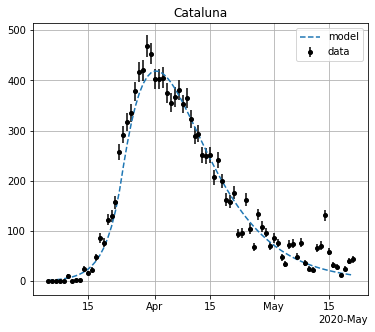

In [52]:
kpars, chi2 = ana_ca('Cataluna', fit = True)

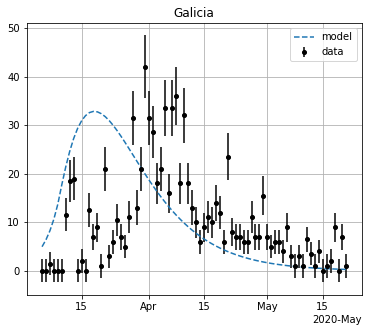

In [79]:
kpars, chi2 = ana_ca('Galicia', fit = False)

Madrid chi2 :  8.628566433978767 , kpars:  {'t0': 41.0, 'beta': 2.0, 'gamma': 0.2, 'tr': 2.0, 'ti': 5.5, 'tm': 10.0, 'n': 6578079.0, 'phi': 0.01, 's1': 0.13205439612385317}
Madrid chi2 :  6.449723248668784 , kpars:  {'t0': 41.0, 'beta': 2.05562710702361, 'gamma': 0.22796420996324748, 'tr': 2.0, 'ti': 5.5, 'tm': 10.0, 'n': 6578079.0, 'phi': 0.01, 's1': 0.13205439612385317}
Castilla y Leon chi2 :  2.4480829353383204 , kpars:  {'t0': 33.0, 'beta': 2.0, 'gamma': 0.2, 'tr': 2.0, 'ti': 5.5, 'tm': 10.0, 'n': 2409164.0, 'phi': 0.01, 's1': 0.10176844540263763}
Castilla y Leon chi2 :  2.4215073012746657 , kpars:  {'t0': 33.0, 'beta': 1.9980807100928286, 'gamma': 0.2028836266412576, 'tr': 2.0, 'ti': 5.5, 'tm': 10.0, 'n': 2409164.0, 'phi': 0.01, 's1': 0.10176844540263763}
Castilla La Mancha chi2 :  6.458058270631439 , kpars:  {'t0': 36.0, 'beta': 2.0, 'gamma': 0.2, 'tr': 2.0, 'ti': 5.5, 'tm': 10.0, 'n': 2026807.0, 'phi': 0.01, 's1': 0.18510112210980123}
Castilla La Mancha chi2 :  6.144415394739681

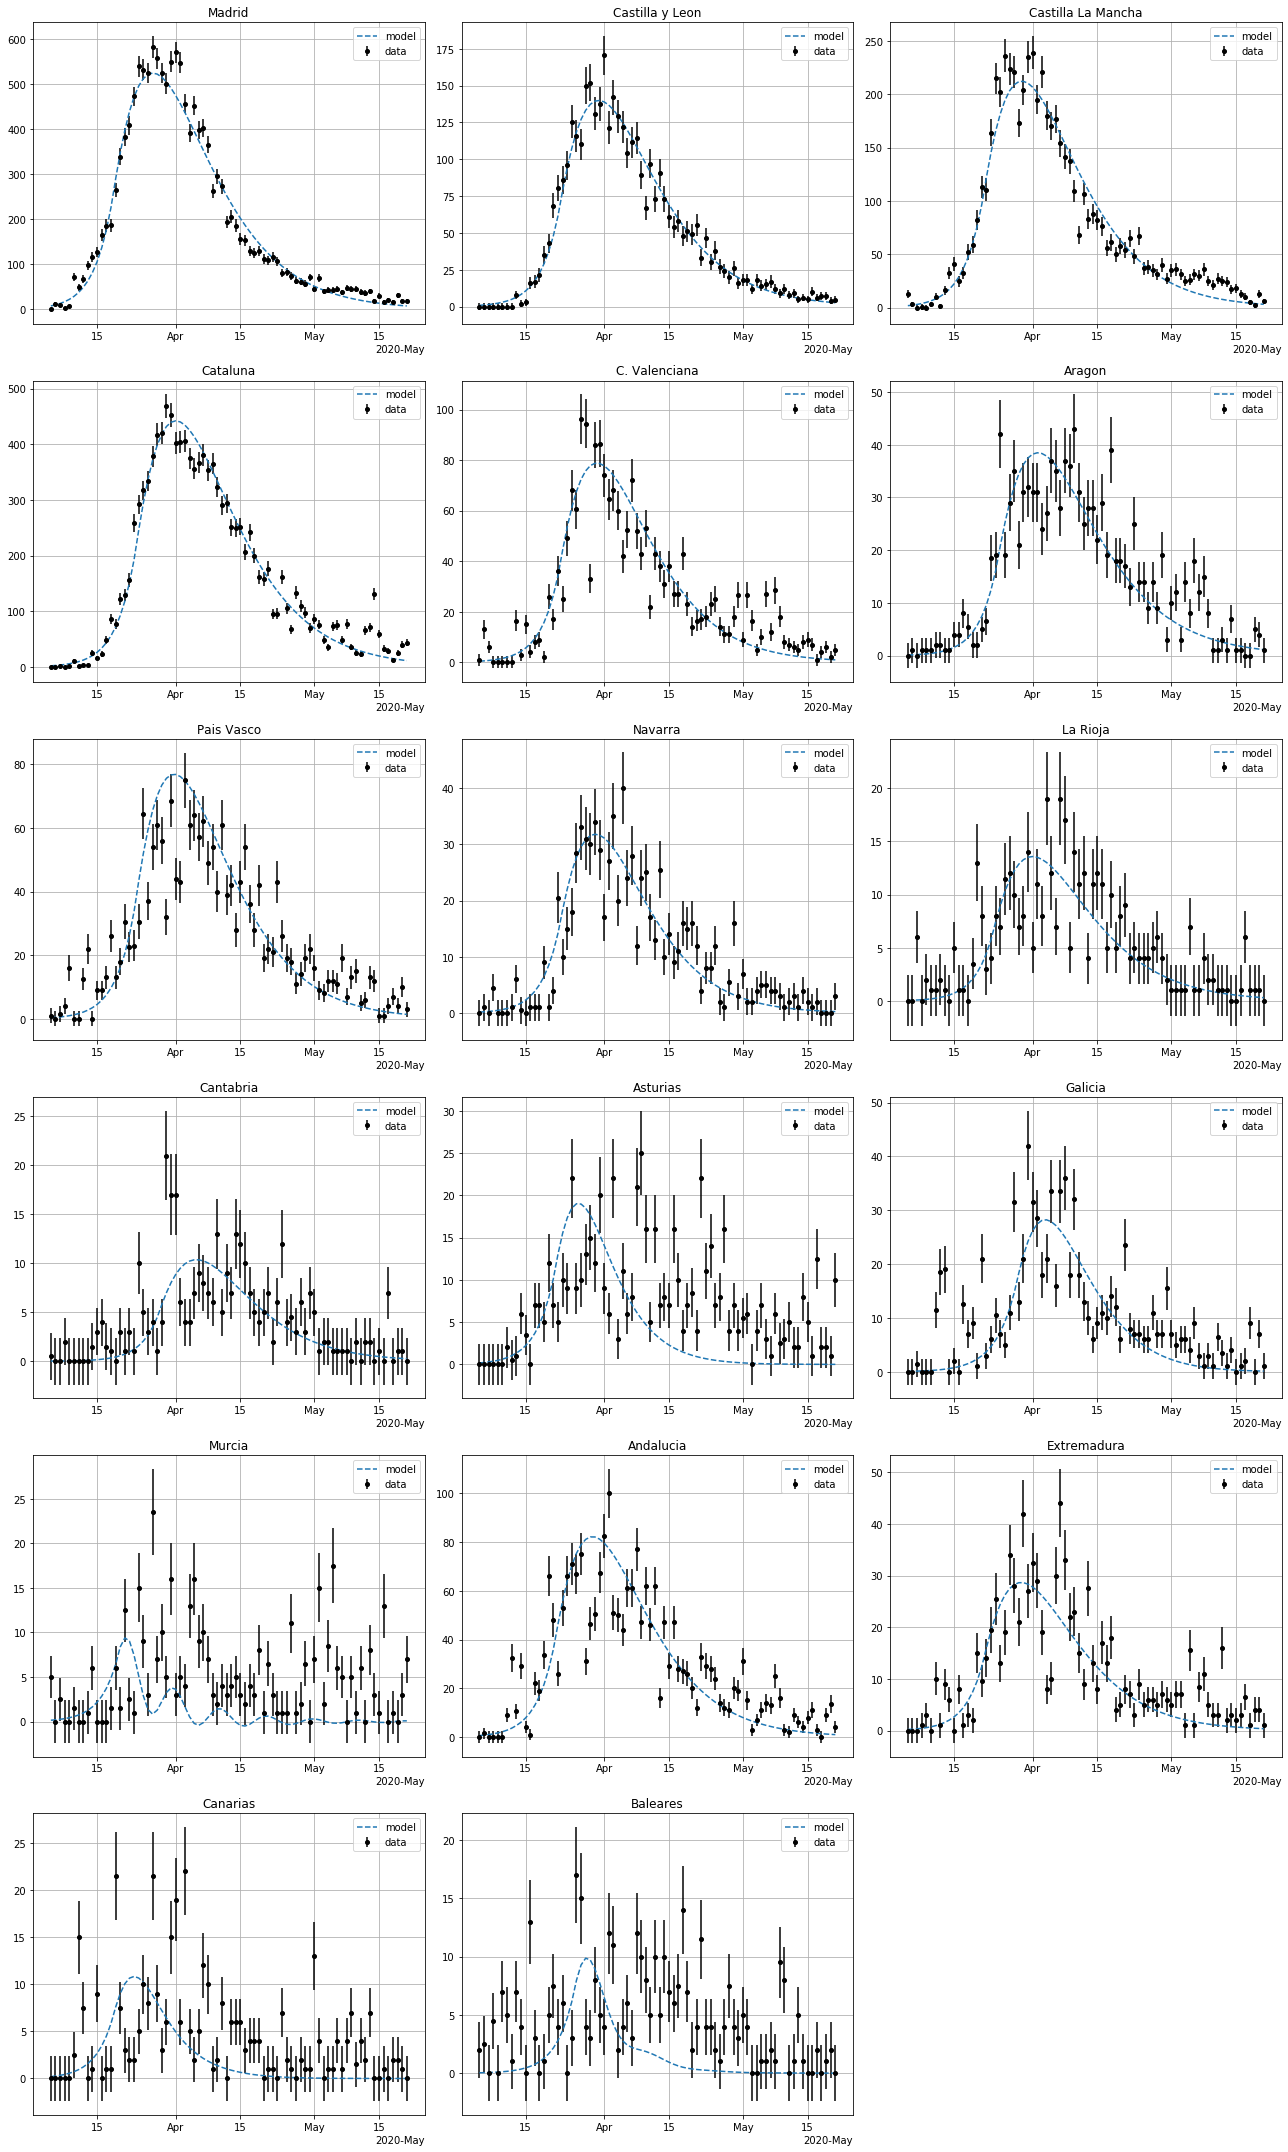

In [86]:
canames = ['Madrid', 'Castilla y Leon', 'Castilla La Mancha',
           'Cataluna', 'C. Valenciana', 'Aragon',
           'Pais Vasco', 'Navarra', 'La Rioja',
           'Cantabria', 'Asturias', 'Galicia',
           'Murcia', 'Andalucia', 'Extremadura',
           'Canarias', 'Baleares']

ncols, nrows = 3, 6
plt.figure(figsize = (ncols * 6, nrows * 5))

capars = {}
for i, caname in enumerate(canames):
    ax = plt.subplot(nrows, ncols, i + 1, axisbelow=True)
    pars, chi2 = ana_ca(caname, fit = True)
    capars[caname] = pars
    plt.title(caname)
plt.tight_layout()

Madrid chi2 :  6.512318009112994 , kpars:  {'t0': 41.122518887916, 'beta': 2.05562710702361, 'gamma': 0.22796420996324748, 'tr': 2.078759369104167, 'ti': 5.5, 'tm': 10.0, 'n': 6578079.0, 'phi': 0.008504261589019992, 's1': 0.13205439612385317}
Castilla y Leon chi2 :  2.304196391130497 , kpars:  {'t0': 33.58129347721639, 'beta': 1.9980807100928286, 'gamma': 0.2028836266412576, 'tr': 2.1213299106731673, 'ti': 5.5, 'tm': 10.0, 'n': 2409164.0, 'phi': 0.007627971951791981, 's1': 0.10176844540263763}
Castilla La Mancha chi2 :  6.1365672419525215 , kpars:  {'t0': 36.003982967121146, 'beta': 1.9937724797512335, 'gamma': 0.22318894683876514, 'tr': 2.0012156888970836, 'ti': 5.5, 'tm': 10.0, 'n': 2026807.0, 'phi': 0.009660380938598702, 's1': 0.18510112210980123}
Cataluna chi2 :  9.182063234072633 , kpars:  {'t0': 37.64566462246839, 'beta': 1.9722199952548896, 'gamma': 0.21806379991754782, 'tr': 2.1085212544504426, 'ti': 5.5, 'tm': 10.0, 'n': 7600065.0, 'phi': 0.007626998421459507, 's1': 0.10074994

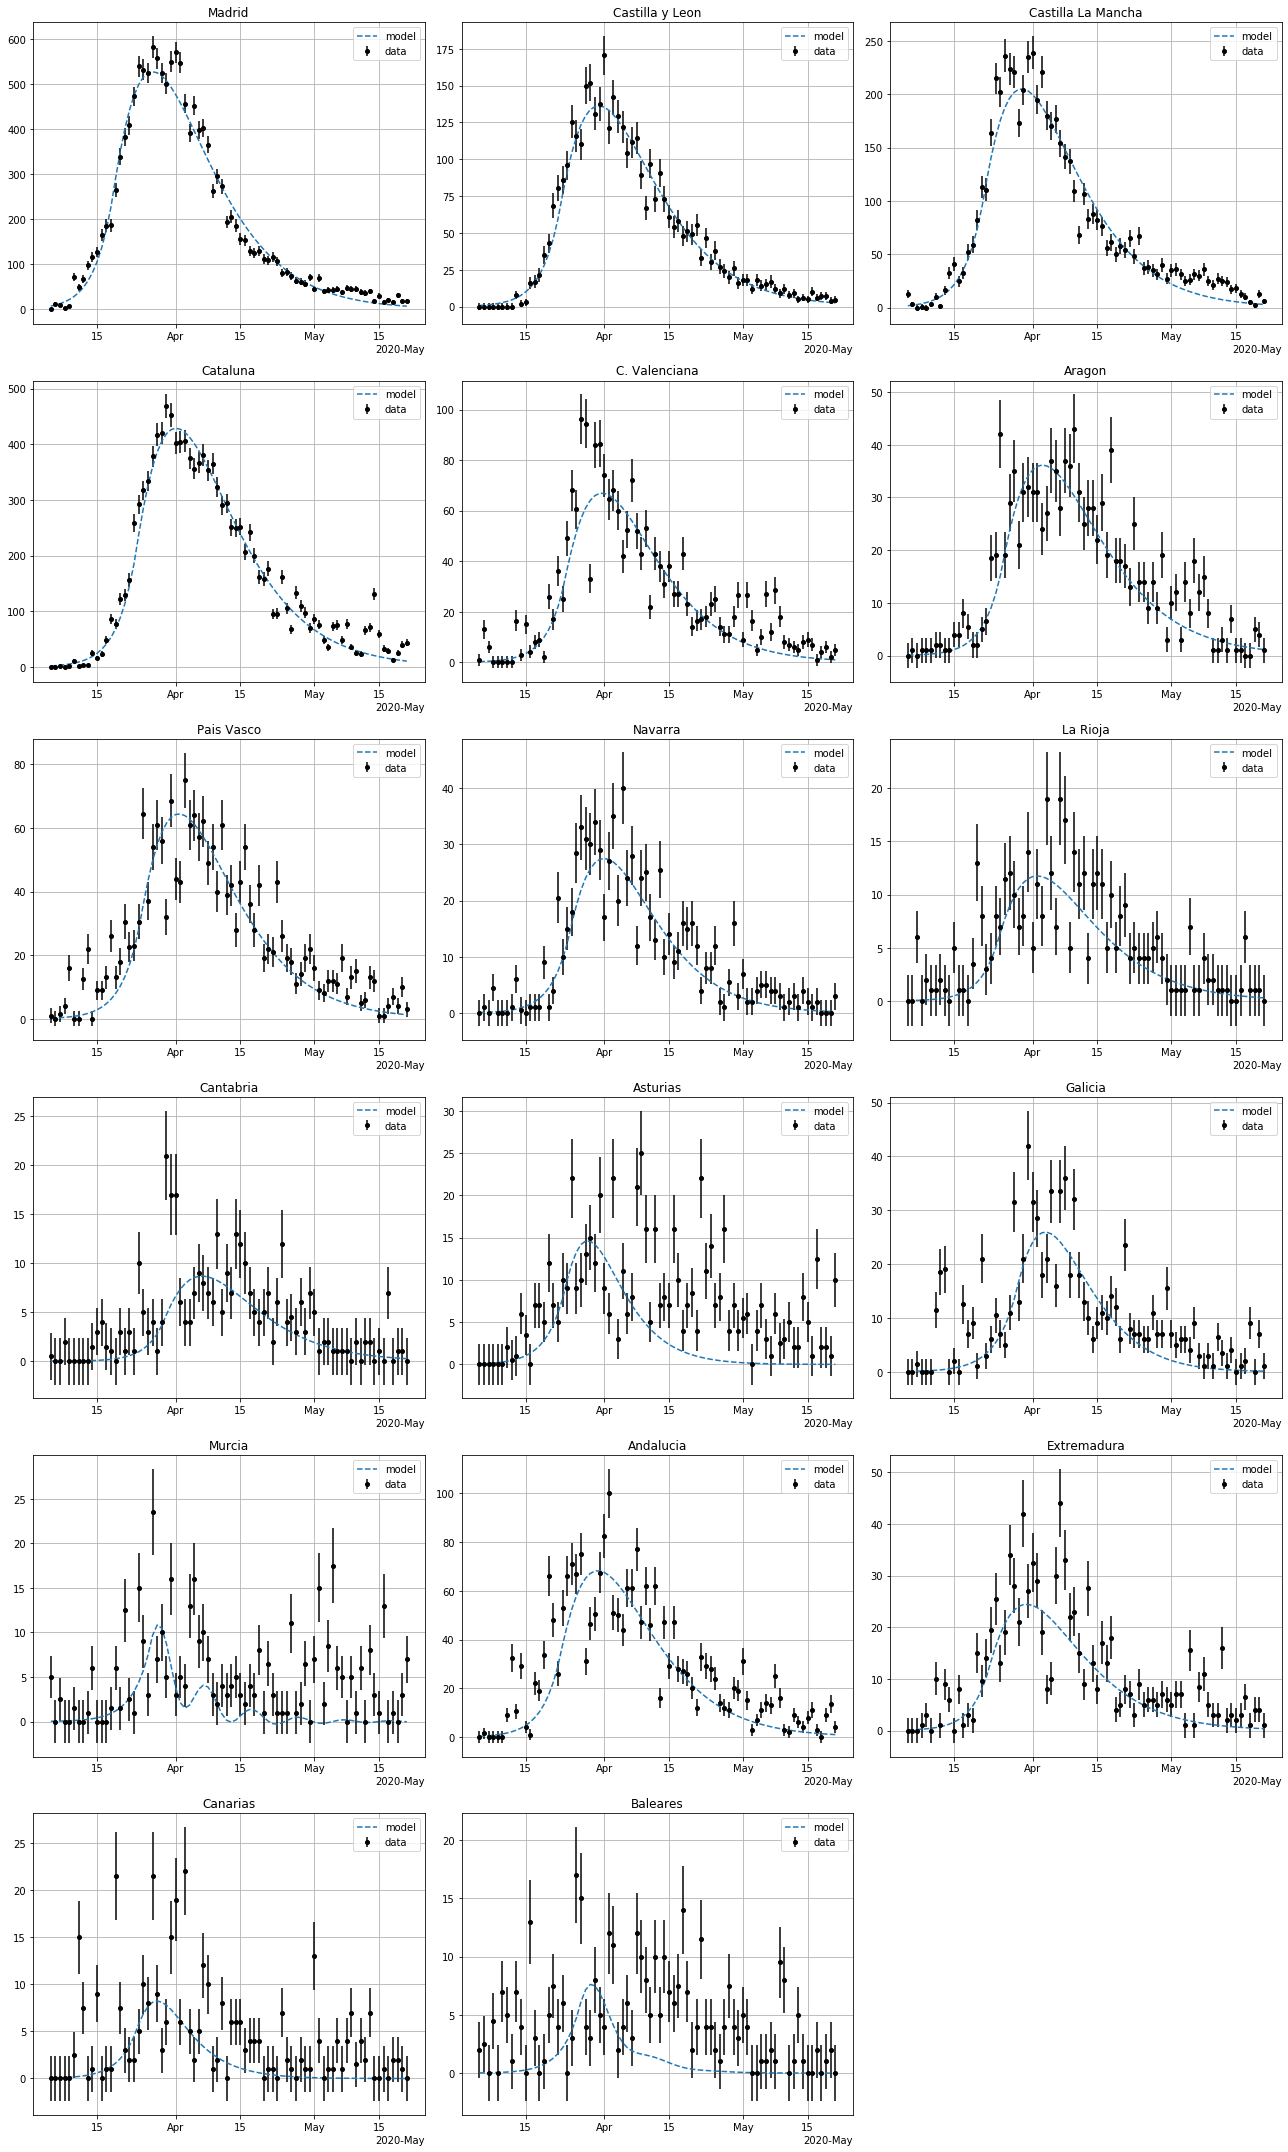

In [93]:
ncols, nrows = 3, 6
plt.figure(figsize = (ncols * 6, nrows * 5))

capars2 = {}
masks   = (('t0', 'phi', 'tr'),)
for i, caname in enumerate(canames):
    ax = plt.subplot(nrows, ncols, i + 1, axisbelow=True)
    pars, chi2 = ana_ca(caname, kpars = capars[caname], masks = masks, fit = True)
    capars2[caname] = pars
    plt.title(caname)
plt.tight_layout()

In [94]:
f = open('capars.py', 'w')
f.write(str(capars2))
f.close()
#capars2

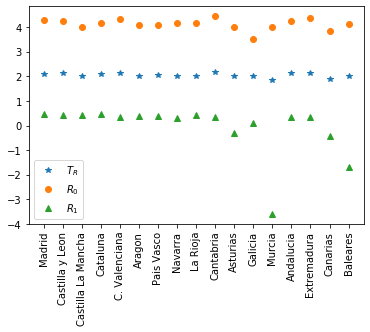

In [95]:
trs    = npa([capars2[caname]['tr']    for caname in canames])
betas  = npa([capars2[caname]['beta']  for caname in canames])
gammas = npa([capars2[caname]['gamma'] for caname in canames])

phis = npa([capars2[caname]['phi'] for caname in canames])
s1s  = npa([capars2[caname]['s1']  for caname in canames])
t0s  = npa([capars2[caname]['t0']  for caname in canames])

plt.plot(trs, ls = '', marker = '*', label = r'$T_R$');
plt.plot(trs * betas, ls = '', marker = 'o', label = r'$R_0$');
plt.plot(trs * gammas, ls = '', marker = '^', label = r'$R_1$');
plt.legend();
plt.xticks(np.arange(len(canames)), canames, rotation = 90);

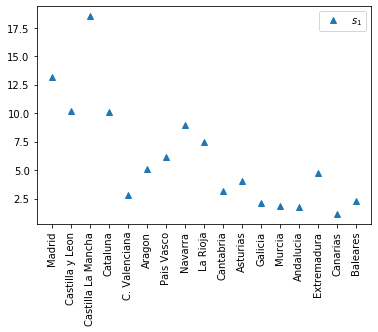

In [104]:
plt.plot(100 * s1s, ls = '', marker = '^', label = r'$s_1$');
plt.legend();
plt.xticks(np.arange(len(canames)), canames, rotation = 90);

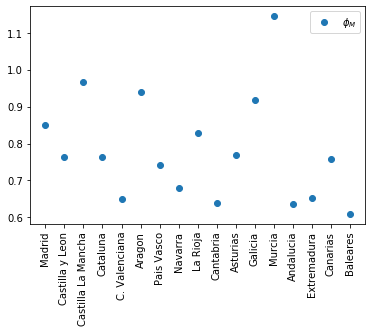

In [102]:
plt.plot(100 * phis, ls = '', marker = 'o', label = r'$\phi_M$');
plt.legend();
plt.xticks(np.arange(len(canames)), canames, rotation = 90);

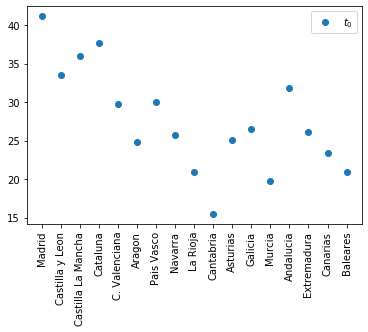

In [103]:
plt.plot(t0s, ls = '', marker = 'o', label = r'$t_0$');
plt.legend();
plt.xticks(np.arange(len(canames)), canames, rotation = 90);

Madrid chi2 :  9.966515022465378 , kpars:  {'t0': 50.0, 'beta': 1.3333333333333333, 'gamma': 0.13333333333333333, 'tr': 3.0, 'ti': 5.5, 'tm': 10.0, 'n': 6578079.0, 'phi': 0.01, 's1': 0.1203533736824991}
Madrid chi2 :  8.94979637057572 , kpars:  {'t0': 50.0, 'beta': 1.3389383242546802, 'gamma': 0.14025803555693828, 'tr': 3.0, 'ti': 5.5, 'tm': 10.0, 'n': 6578079.0, 'phi': 0.01, 's1': 0.1203533736824991}
Castilla y Leon chi2 :  3.6339972905040314 , kpars:  {'t0': 40.0, 'beta': 1.3333333333333333, 'gamma': 0.13333333333333333, 'tr': 3.0, 'ti': 5.5, 'tm': 10.0, 'n': 2409164.0, 'phi': 0.01, 's1': 0.0935801796805863}
Castilla y Leon chi2 :  3.5344180846901363 , kpars:  {'t0': 40.0, 'beta': 1.3306373211244744, 'gamma': 0.126705659367144, 'tr': 3.0, 'ti': 5.5, 'tm': 10.0, 'n': 2409164.0, 'phi': 0.01, 's1': 0.0935801796805863}
Castilla La Mancha chi2 :  8.011335338926106 , kpars:  {'t0': 43.0, 'beta': 1.3333333333333333, 'gamma': 0.13333333333333333, 'tr': 3.0, 'ti': 5.5, 'tm': 10.0, 'n': 202680

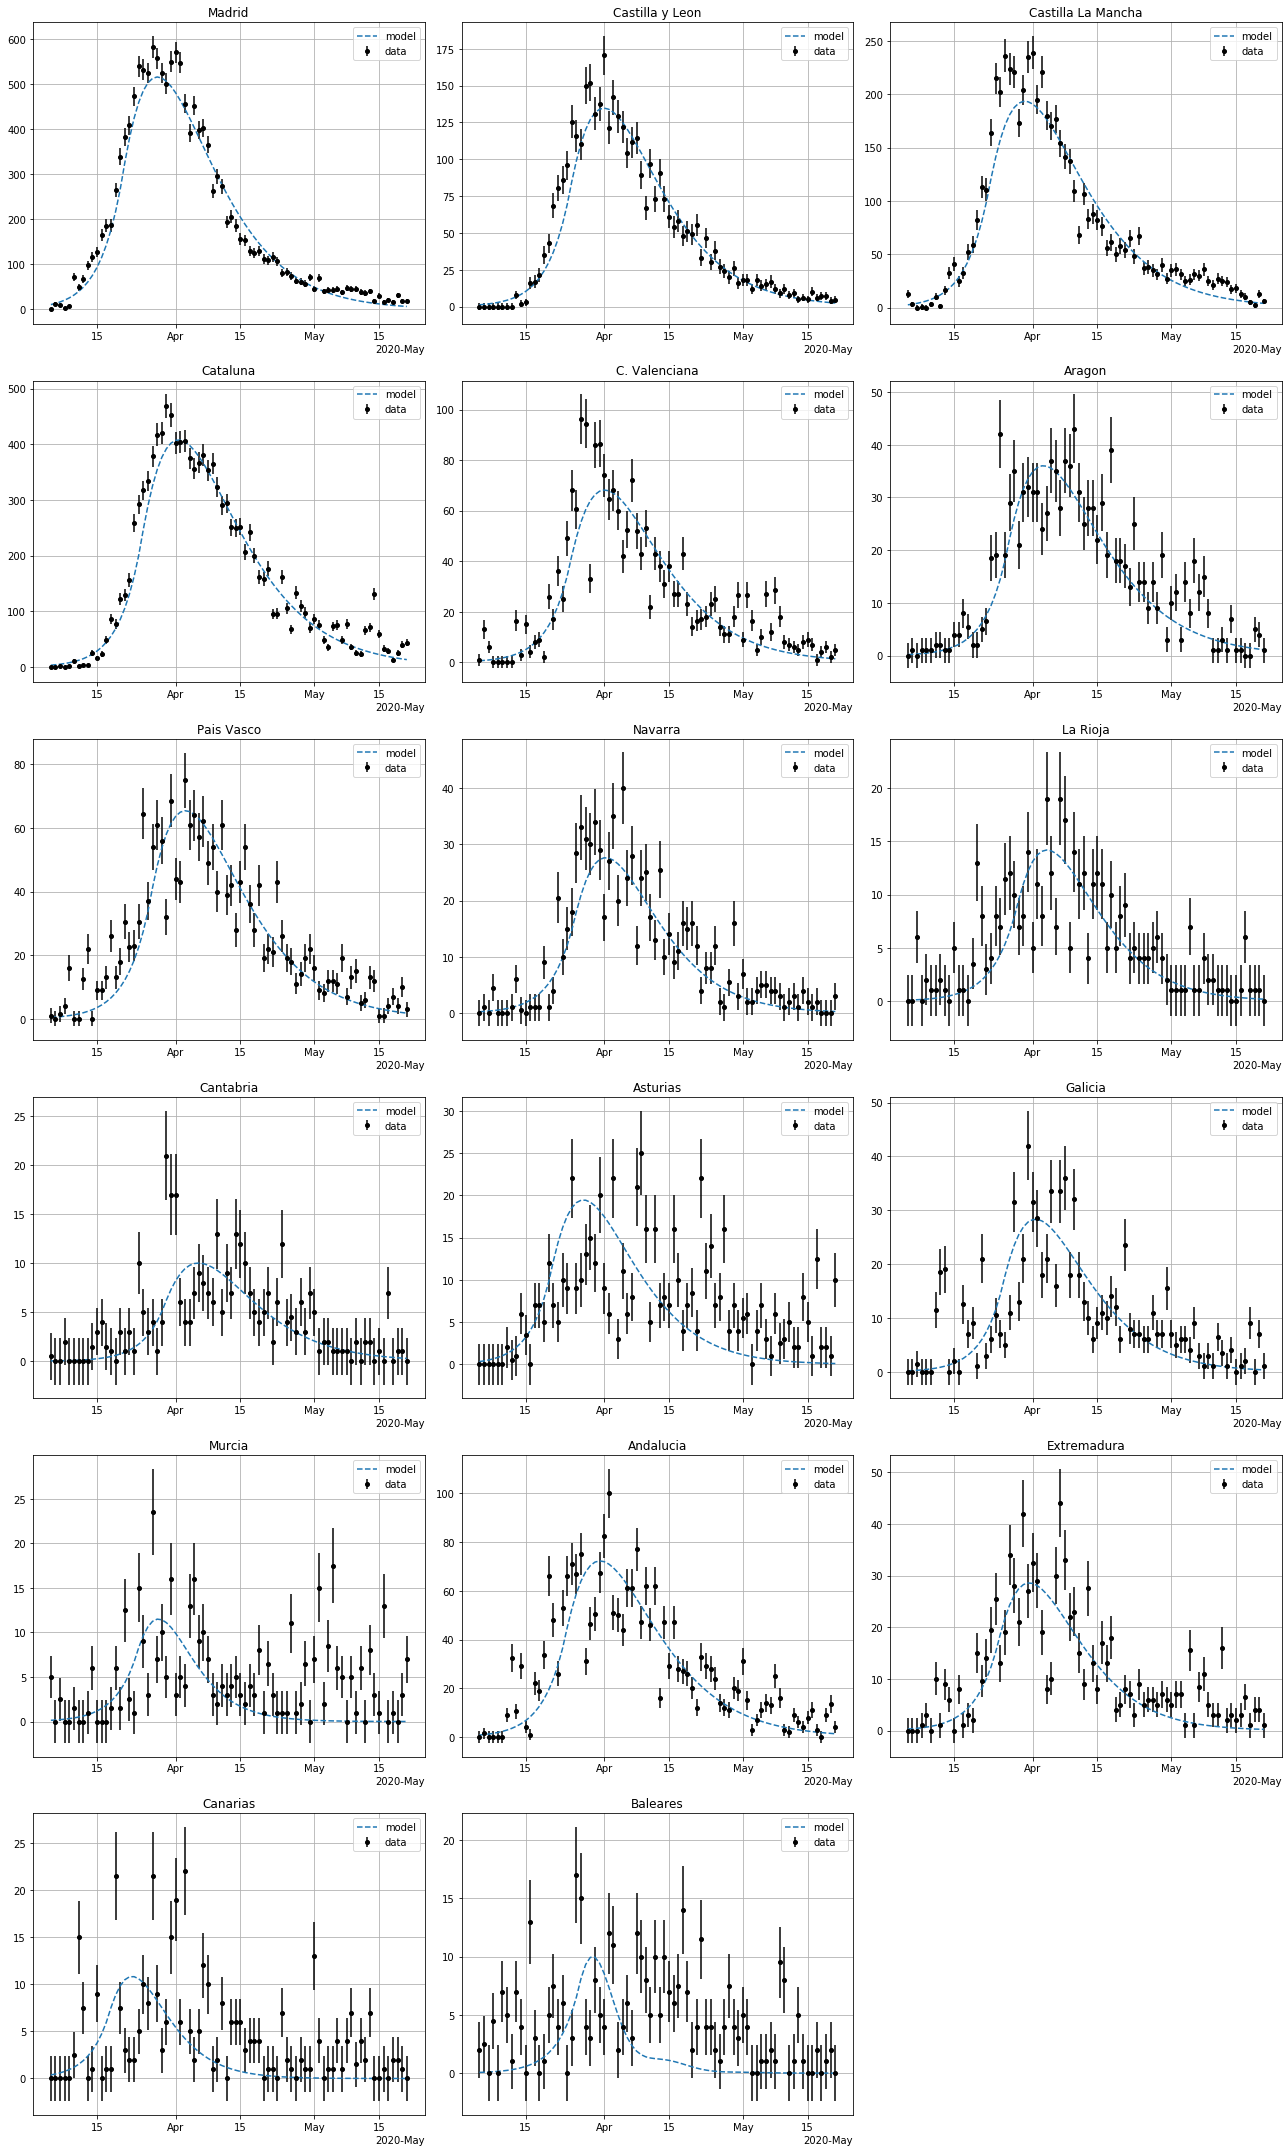

In [105]:
ncols, nrows = 3, 6
plt.figure(figsize = (ncols * 6, nrows * 5))

capars = {}
for i, caname in enumerate(canames):
    ax = plt.subplot(nrows, ncols, i + 1, axisbelow=True)
    pars, chi2 = ana_ca(caname, tr = 3, fit = True)
    capars[caname] = pars
    plt.title(caname)
plt.tight_layout()

Madrid chi2 :  8.94979637057572 , kpars:  {'t0': 50.0, 'beta': 1.3389383242546802, 'gamma': 0.14025803555693828, 'tr': 3.0, 'ti': 5.5, 'tm': 10.0, 'n': 6578079.0, 'phi': 0.01, 's1': 0.1203533736824991}
Madrid chi2 :  9.069126223892026 , kpars:  {'t0': 50.0, 'beta': 1.338938421205337, 'gamma': 0.14025805264855595, 'tr': 2.999999623828464, 'ti': 5.5, 'tm': 10.0, 'n': 6578079.0, 'phi': 0.01, 's1': 0.1203533736824991}
Castilla y Leon chi2 :  3.5332070338635377 , kpars:  {'t0': 40.25869029219017, 'beta': 1.3306373211244744, 'gamma': 0.126705659367144, 'tr': 3.0, 'ti': 5.5, 'tm': 10.0, 'n': 2409164.0, 'phi': 0.009951973582580913, 's1': 0.0935801796805863}
mle: warning
Castilla y Leon chi2 :  3.0051668364359485 , kpars:  {'t0': 40.25869029219017, 'beta': 0.8105332192600496, 'gamma': 0.026990983194107754, 'tr': 11.366182822851727, 'ti': 5.5, 'tm': 10.0, 'n': 2409164.0, 'phi': 0.009951973582580913, 's1': 0.0935801796805863}
Castilla La Mancha chi2 :  7.364148612807367 , kpars:  {'t0': 43.263329

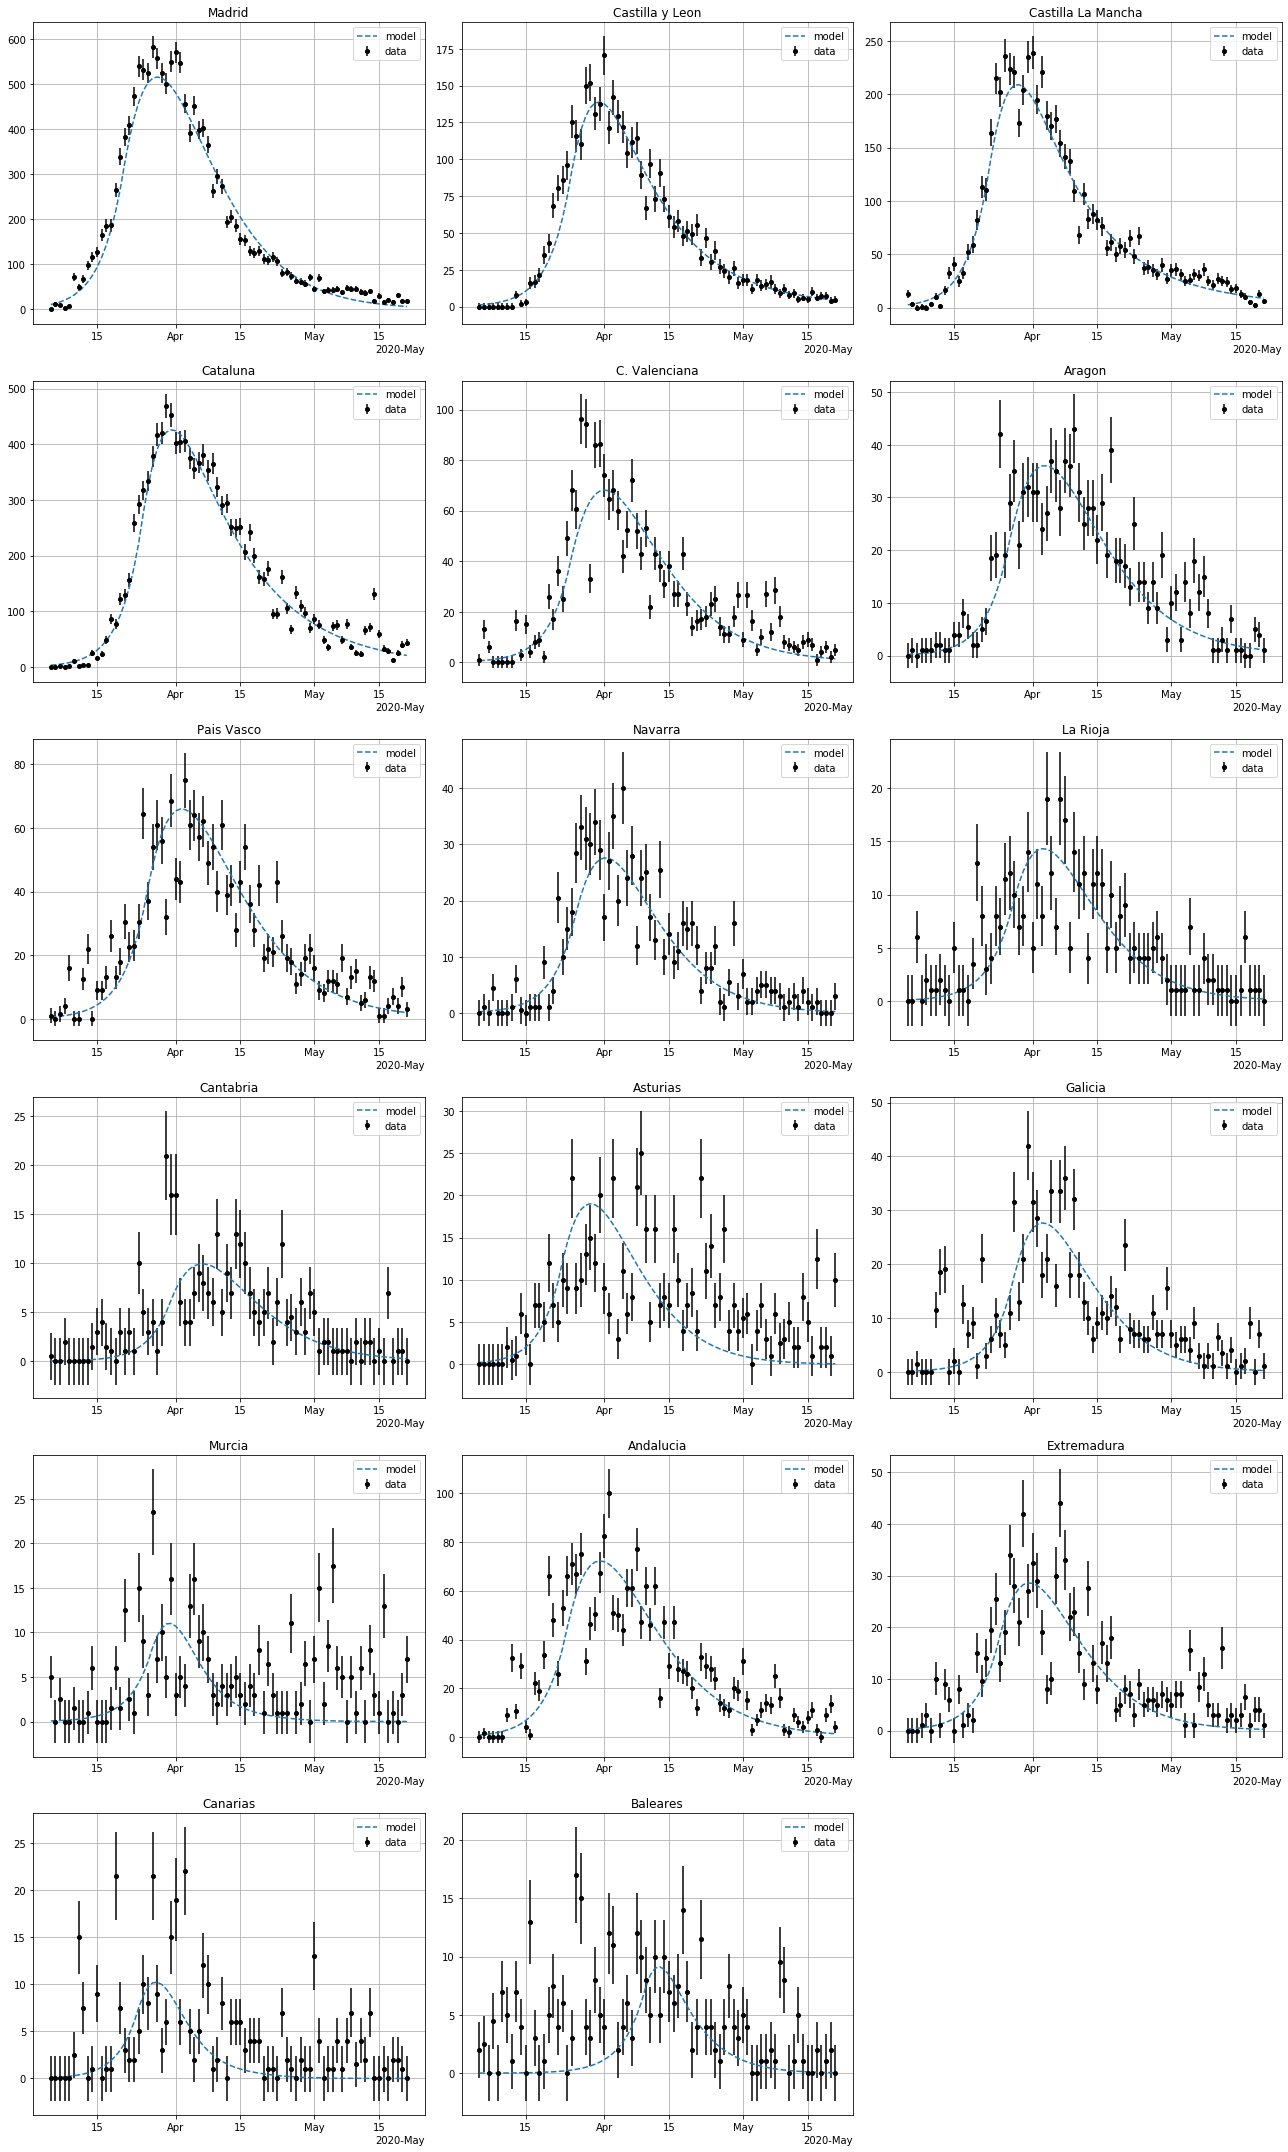

In [107]:
ncols, nrows = 3, 6
plt.figure(figsize = (ncols * 6, nrows * 5))

capars2 = {}
masks   = (('t0', 'phi'), ('beta', 'gamma', 'tr'))
for i, caname in enumerate(canames):
    ax = plt.subplot(nrows, ncols, i + 1, axisbelow=True)
    pars, chi2 = ana_ca(caname, kpars = capars[caname], masks = masks, fit = True)
    capars2[caname] = pars
    cachi2 [caname] = chi2
    plt.title(caname)
plt.tight_layout()

In [108]:
f = open('capars3.py', 'w')
f.write(str(capars2))
f.close()
#capars2

## --- code ana

In [32]:
x = {}
'hello' in x.keys() 

False

In [60]:
canames = ['Madrid', 'Castilla y Leon', 'Castilla La Mancha',
           'Cataluna', 'C. Valenciana', 'Aragon',
           'Pais Vasco', 'Navarra', 'La Rioja',
           'Cantabria', 'Asturias', 'Galicia',
           'Murcia', 'Andalucia', 'Extremadura',
           'Canarias', 'Baleares']

def ana_ca(caname, tr = 2., kpars = None, masks = None, fit = False):
    
    dates, cases, ucases = ca_cases(caname)
    ts                   = np.arange(len(dates))

    n0  = nn[caname]
    phi = 0.01
    s1  = 0.6 * np.sum(cases)/(n0 * phi)
    fi  = tr/2.
    
    kpars =  {'t0': 40.0, 'beta': 2./fi, 'gamma': 0.2/fi, 'tr': 2.*fi, 'ti': 5.5, 
               'tm': 10., 'n': n0, 'phi': phi, 's1': s1} if kpars is None else kpars
    #masks = (('t0', 's1'), ('beta', 'gamma'), ('t0', 'phi'), ('phi', 's1'), ('beta', 'tr'), ('gamma', 'tr'))
    #masks = 2*(('t0', 's1'), ('beta', 'gamma'), ('phi', 'tr'))
    #print('kpars', kpars)
    masks = (('t0', 's1'), ('beta', 'gamma')) if masks is None else masks
    chi2 = 0.
    if (fit):
        tbar = IntProgress(0, max = len(masks), description = caname); display(tbar)
        for imask in masks:
            tbar.value += 1
            kpars, chi2 = usa.useirqm_chi2fit(dates, cases, kpars = kpars, kmask = imask)
            #print(caname, 'chi2 : ', chi2, ', kpars: ', kpars, ', mask ', imask)
    fmodel      = usa.useirqm_fmodel(kpars = kpars)
    usa.plot_data_model(dates, cases, fmodel)
    plt.title(caname)
    return kpars, chi2


def ana_capars(masks, canames = canames, capars = {}, fit = False, ofilename = None):
    ncols, nrows = 3, int(len(canames)/3)
    if (len(canames) % 3 != 0): nrows += 1

    plt.figure(figsize = (ncols * 6, nrows * 5))
    
    f = open(ofilename, 'w') if ofilename is not None else None
      
    capars2, cachi2 = {}, {}
    for i, caname in enumerate(canames):
        ax    = plt.subplot(nrows, ncols, i + 1, axisbelow=True)
        kpars = capars[caname] if caname in capars.keys() else None
        pars, chi2 = ana_ca(caname, kpars = kpars, masks = masks, fit = fit)
        if (f is not None):
            ss = str(caname)+', '+str(pars)+', '+str(chi2)+'\n'
            f.write(ss)
        else: 
            print(caname, chi2, pars)
        capars2[caname] = pars
        cachi2 [caname] = chi2
        plt.title(caname)
    plt.tight_layout()
    
    if (f is not None): f.close()
    
    return capars2, cachi2

def plot_capars(capars, cachi2, canames = None):
    
    canames = capars.keys() if canames is None else canames
    
    trs    = npa([capars[caname]['tr']    for caname in canames])
    betas  = npa([capars[caname]['beta']  for caname in canames])
    gammas = npa([capars[caname]['gamma'] for caname in canames])

    phis = npa([capars[caname]['phi'] for caname in canames])
    s1s  = npa([capars[caname]['s1']  for caname in canames])
    t0s  = npa([capars[caname]['t0']  for caname in canames])

    plt.figure(figsize = (8, 5))
    plt.plot(trs, ls = '', marker = '*', label = r'$T_R$');
    plt.plot(trs * betas, ls = '', marker = 'o', label = r'$R_0$');
    plt.plot(trs * gammas, ls = '', marker = '^', label = r'$R_1$');
    plt.legend(); plt.grid()
    plt.xticks(np.arange(len(canames)), canames, rotation = 90);
    
    plt.figure(figsize = (8, 5))
    plt.plot(100 * s1s , ls = '', marker = '^', label = r'$s_1$');
    plt.plot(100 * phis, ls = '', marker = '^', label = r'$s_1$');
    plt.legend(); plt.grid();
    plt.xticks(np.arange(len(canames)), canames, rotation = 90);
    
    plt.figure(figsize = (8, 5))
    plt.plot(t0s, ls = '', marker = '^', label = r'$t_0$');
    plt.legend(); plt.grid();
    plt.xticks(np.arange(len(canames)), canames, rotation = 90);
    
    chis  = npa([cachi2[caname] for caname in canames])
    
    plt.figure(figsize = (8, 5))
    plt.plot(chi2, ls = '', marker = '^', label = r'$t_0$');
    plt.legend(); plt.grid();
    plt.xticks(np.arange(len(canames)), canames, rotation = 90);
    return

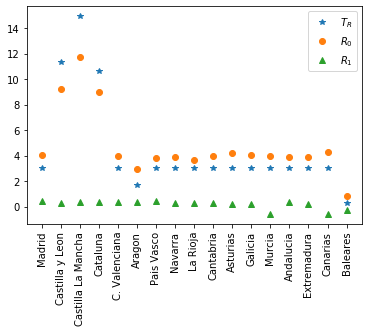

In [109]:
trs    = npa([capars2[caname]['tr']    for caname in canames])
betas  = npa([capars2[caname]['beta']  for caname in canames])
gammas = npa([capars2[caname]['gamma'] for caname in canames])

phis = npa([capars2[caname]['phi'] for caname in canames])
s1s  = npa([capars2[caname]['s1']  for caname in canames])
t0s  = npa([capars2[caname]['t0']  for caname in canames])

plt.plot(trs, ls = '', marker = '*', label = r'$T_R$');
plt.plot(trs * betas, ls = '', marker = 'o', label = r'$R_0$');
plt.plot(trs * gammas, ls = '', marker = '^', label = r'$R_1$');
plt.legend();
plt.xticks(np.arange(len(canames)), canames, rotation = 90);

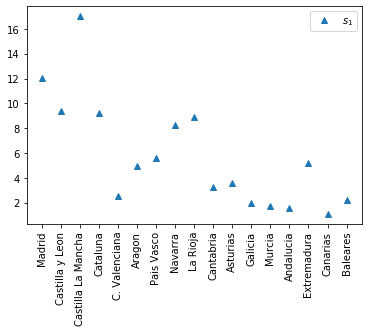

In [110]:
plt.plot(100 * s1s, ls = '', marker = '^', label = r'$s_1$');
plt.legend();
plt.xticks(np.arange(len(canames)), canames, rotation = 90);

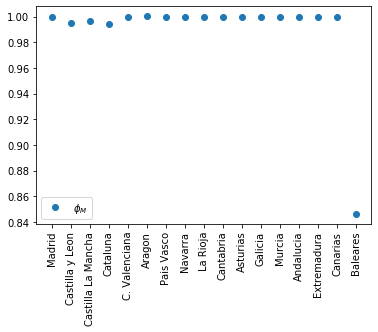

In [111]:
plt.plot(100 * phis, ls = '', marker = 'o', label = r'$\phi_M$');
plt.legend();
plt.xticks(np.arange(len(canames)), canames, rotation = 90);

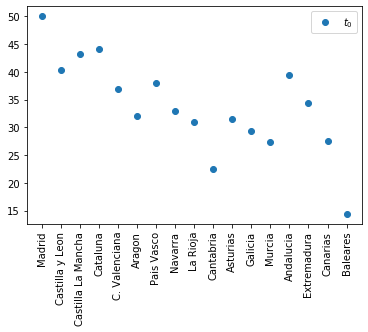

In [112]:
plt.plot(t0s, ls = '', marker = 'o', label = r'$t_0$');
plt.legend();
plt.xticks(np.arange(len(canames)), canames, rotation = 90);

Madrid chi2 :  8.94979637057572 , kpars:  {'t0': 50.0, 'beta': 1.3389383242546802, 'gamma': 0.14025803555693828, 'tr': 3.0, 'ti': 5.5, 'tm': 10.0, 'n': 6578079.0, 'phi': 0.01, 's1': 0.1203533736824991}
Madrid chi2 :  8.949795501365685 , kpars:  {'t0': 50.0, 'beta': 1.3389383533936372, 'gamma': 0.14025803555693828, 'tr': 2.9999999318536372, 'ti': 5.5, 'tm': 10.0, 'n': 6578079.0, 'phi': 0.01, 's1': 0.1203533736824991}
Madrid chi2 :  8.949795501365685 , kpars:  {'t0': 50.0, 'beta': 1.3389383533936372, 'gamma': 0.14025803555693828, 'tr': 2.9999999318536372, 'ti': 5.5, 'tm': 10.0, 'n': 6578079.0, 'phi': 0.01, 's1': 0.1203533736824991}
Castilla y Leon chi2 :  3.5332070338635377 , kpars:  {'t0': 40.25869029219017, 'beta': 1.3306373211244744, 'gamma': 0.126705659367144, 'tr': 3.0, 'ti': 5.5, 'tm': 10.0, 'n': 2409164.0, 'phi': 0.009951973582580913, 's1': 0.0935801796805863}
Castilla y Leon chi2 :  3.5283141277141548 , kpars:  {'t0': 40.25869029219017, 'beta': 1.3174560128199078, 'gamma': 0.1267

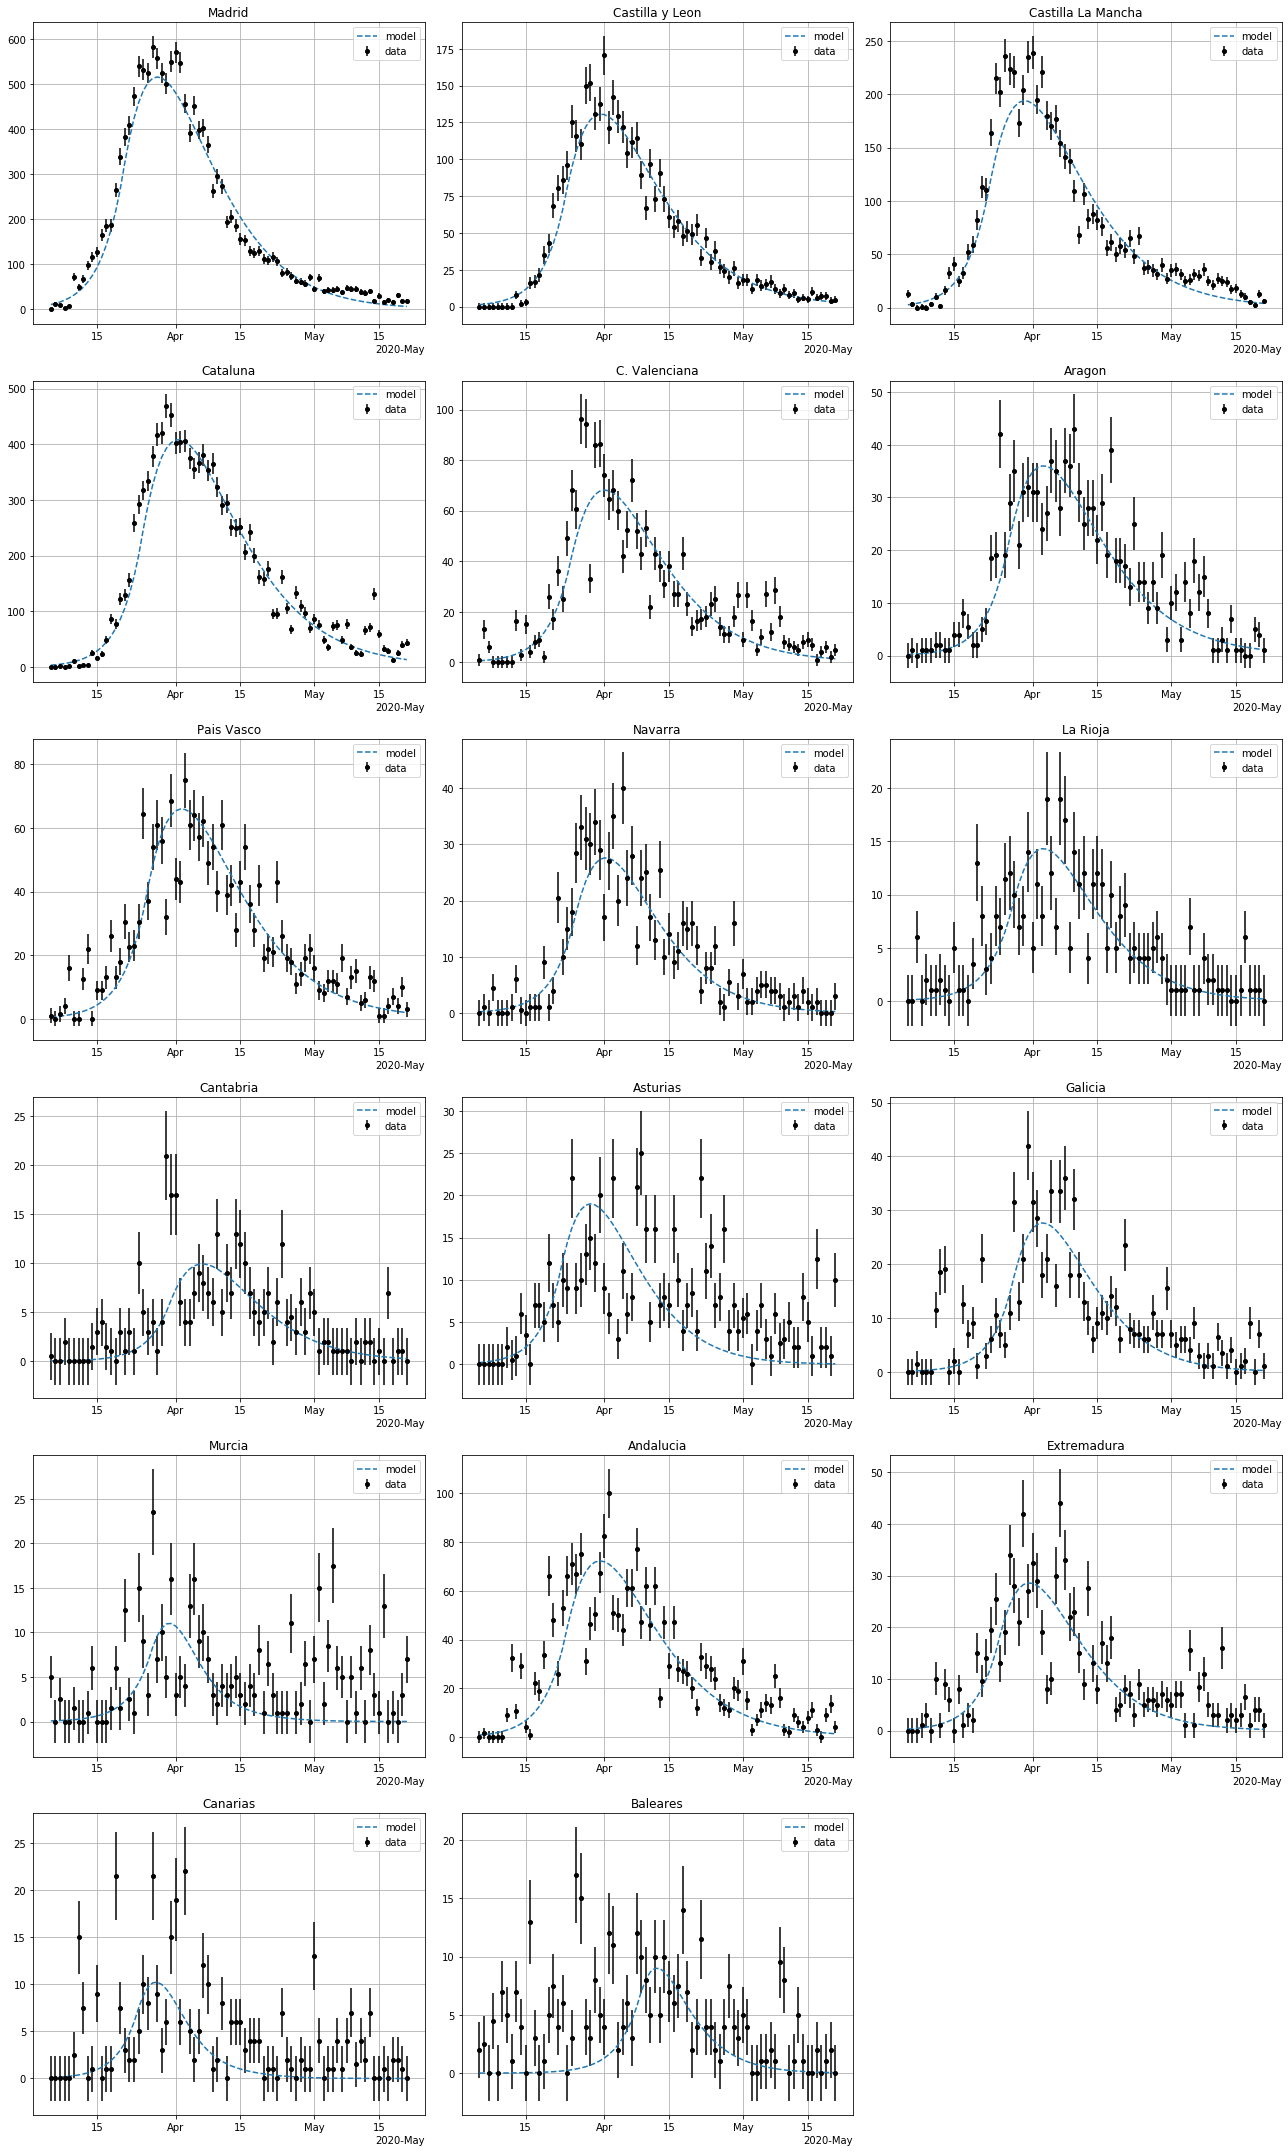

In [114]:
ncols, nrows = 3, 6
plt.figure(figsize = (ncols * 6, nrows * 5))

capars2 = {}
masks   = (('t0', 'phi'), ('beta', 'tr'), ('gamma', 'tr'))
for i, caname in enumerate(canames):
    ax = plt.subplot(nrows, ncols, i + 1, axisbelow=True)
    pars, chi2 = ana_ca(caname, kpars = capars[caname], masks = masks, fit = True)
    capars2[caname] = pars
    plt.title(caname)
plt.tight_layout()

Madrid chi2 :  8.94979637057572 , kpars:  {'t0': 50.0, 'beta': 1.3389383242546802, 'gamma': 0.14025803555693828, 'tr': 3.0, 'ti': 5.5, 'tm': 10.0, 'n': 6578079.0, 'phi': 0.01, 's1': 0.1203533736824991}
Madrid chi2 :  8.949795501365685 , kpars:  {'t0': 50.0, 'beta': 1.3389383533936372, 'gamma': 0.14025803555693828, 'tr': 2.9999999318536372, 'ti': 5.5, 'tm': 10.0, 'n': 6578079.0, 'phi': 0.01, 's1': 0.1203533736824991}
Madrid chi2 :  8.949795501365685 , kpars:  {'t0': 50.0, 'beta': 1.3389383533936372, 'gamma': 0.14025803555693828, 'tr': 2.9999999318536372, 'ti': 5.5, 'tm': 10.0, 'n': 6578079.0, 'phi': 0.01, 's1': 0.1203533736824991}
Castilla y Leon chi2 :  3.5332070338635377 , kpars:  {'t0': 40.25869029219017, 'beta': 1.3306373211244744, 'gamma': 0.126705659367144, 'tr': 3.0, 'ti': 5.5, 'tm': 10.0, 'n': 2409164.0, 'phi': 0.009951973582580913, 's1': 0.0935801796805863}
Castilla y Leon chi2 :  3.5283141277141548 , kpars:  {'t0': 40.25869029219017, 'beta': 1.3174560128199078, 'gamma': 0.1267

ValueError: too many values to unpack (expected 2)

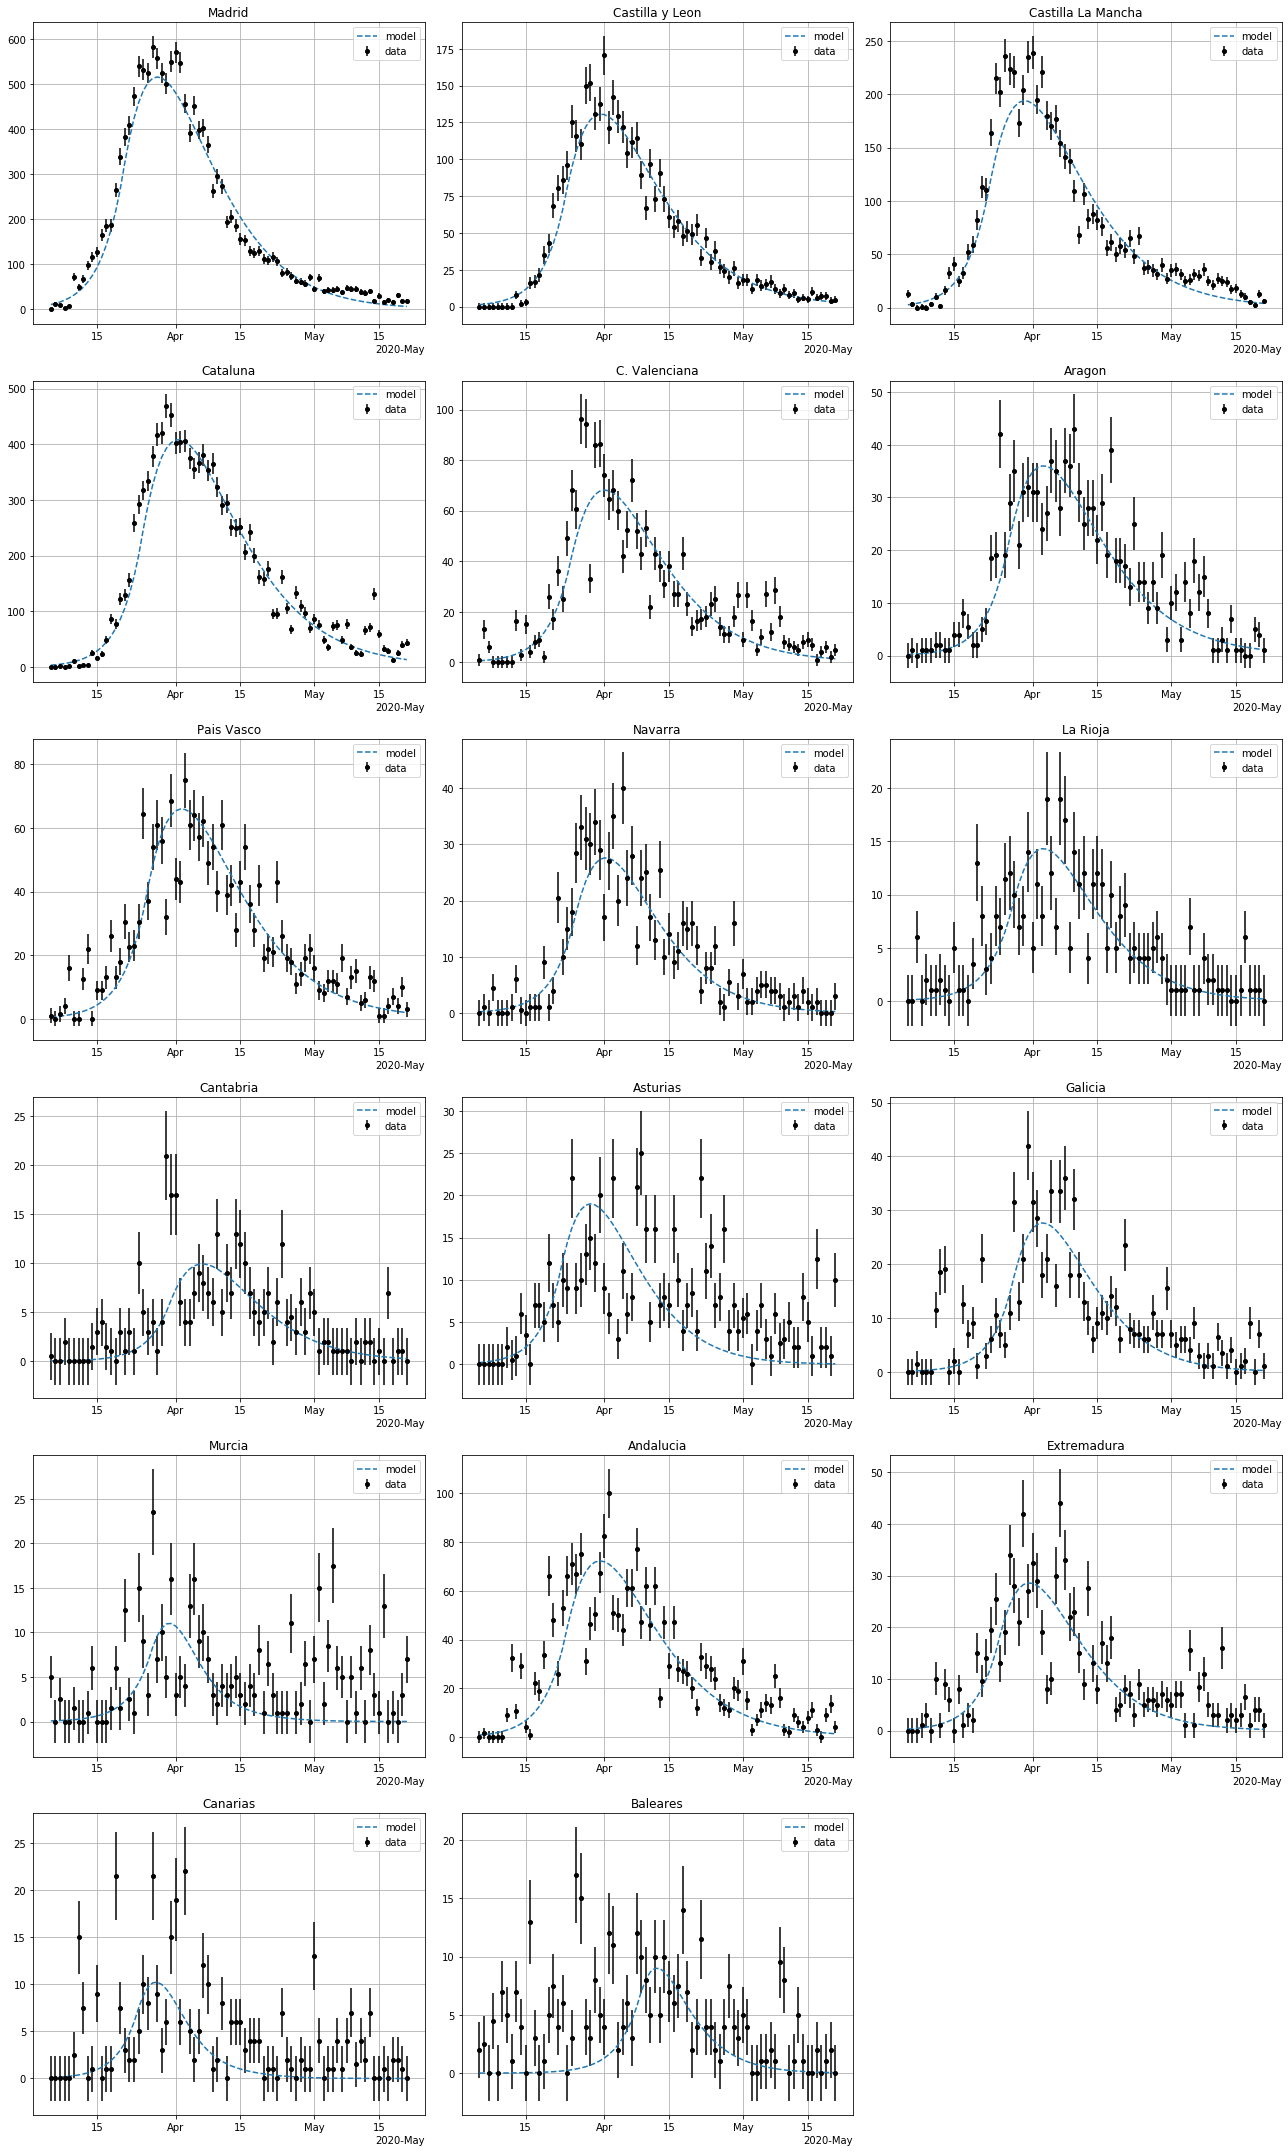

In [137]:
masks   = (('t0', 'phi'), ('beta', 'tr'), ('gamma', 'tr'))
capars3, cachi3 = ana_capars(masks, capars = capars, fit = True)

### Here

IntProgress(value=0, description='Madrid', max=2)

IntProgress(value=0, description='Castilla y Leon', max=2)

IntProgress(value=0, description='Castilla La Mancha', max=2)

IntProgress(value=0, description='Cataluna', max=2)

IntProgress(value=0, description='C. Valenciana', max=2)

IntProgress(value=0, description='Aragon', max=2)

IntProgress(value=0, description='Pais Vasco', max=2)

IntProgress(value=0, description='Navarra', max=2)

IntProgress(value=0, description='La Rioja', max=2)

IntProgress(value=0, description='Cantabria', max=2)

IntProgress(value=0, description='Asturias', max=2)

IntProgress(value=0, description='Galicia', max=2)

IntProgress(value=0, description='Murcia', max=2)

IntProgress(value=0, description='Andalucia', max=2)

IntProgress(value=0, description='Extremadura', max=2)

IntProgress(value=0, description='Canarias', max=2)

IntProgress(value=0, description='Baleares', max=2)

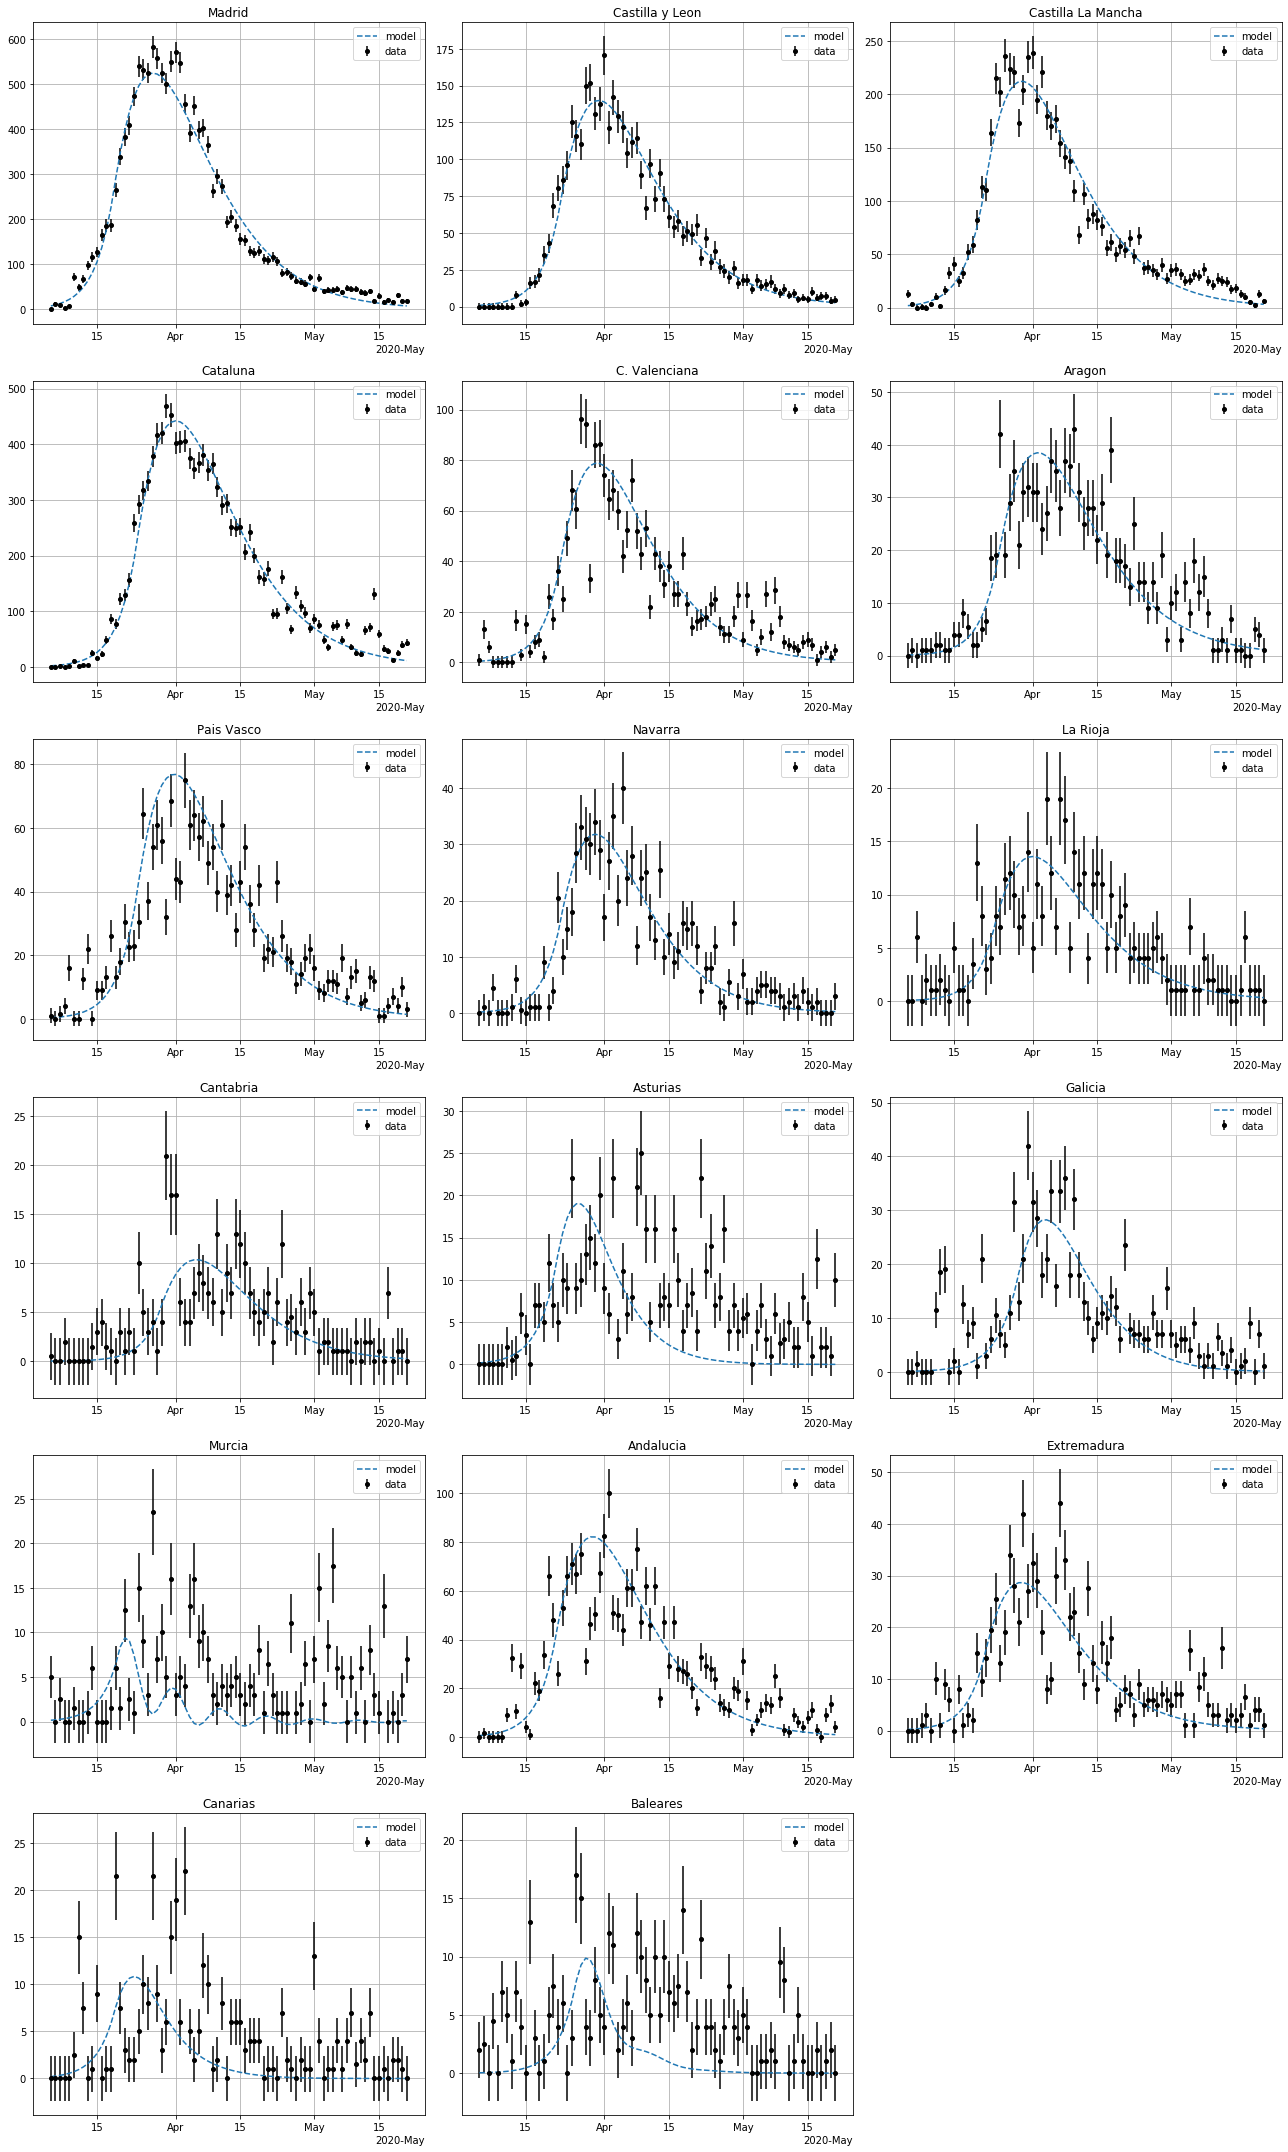

In [79]:
masks   = (('s1', 't0'), ('beta', 'gamma'))
capars1, cachi21 = ana_capars(masks, canames = canames, capars = {}, fit = True, ofilename = 'capars0.txt')

IntProgress(value=0, description='Madrid', max=3)

IntProgress(value=0, description='Castilla y Leon', max=3)

IntProgress(value=0, description='Castilla La Mancha', max=3)

IntProgress(value=0, description='Cataluna', max=3)

IntProgress(value=0, description='C. Valenciana', max=3)

IntProgress(value=0, description='Aragon', max=3)

IntProgress(value=0, description='Pais Vasco', max=3)

IntProgress(value=0, description='Navarra', max=3)

IntProgress(value=0, description='La Rioja', max=3)

IntProgress(value=0, description='Cantabria', max=3)

IntProgress(value=0, description='Asturias', max=3)

IntProgress(value=0, description='Galicia', max=3)

IntProgress(value=0, description='Murcia', max=3)

mle: warning


IntProgress(value=0, description='Andalucia', max=3)

IntProgress(value=0, description='Extremadura', max=3)

IntProgress(value=0, description='Canarias', max=3)

IntProgress(value=0, description='Baleares', max=3)

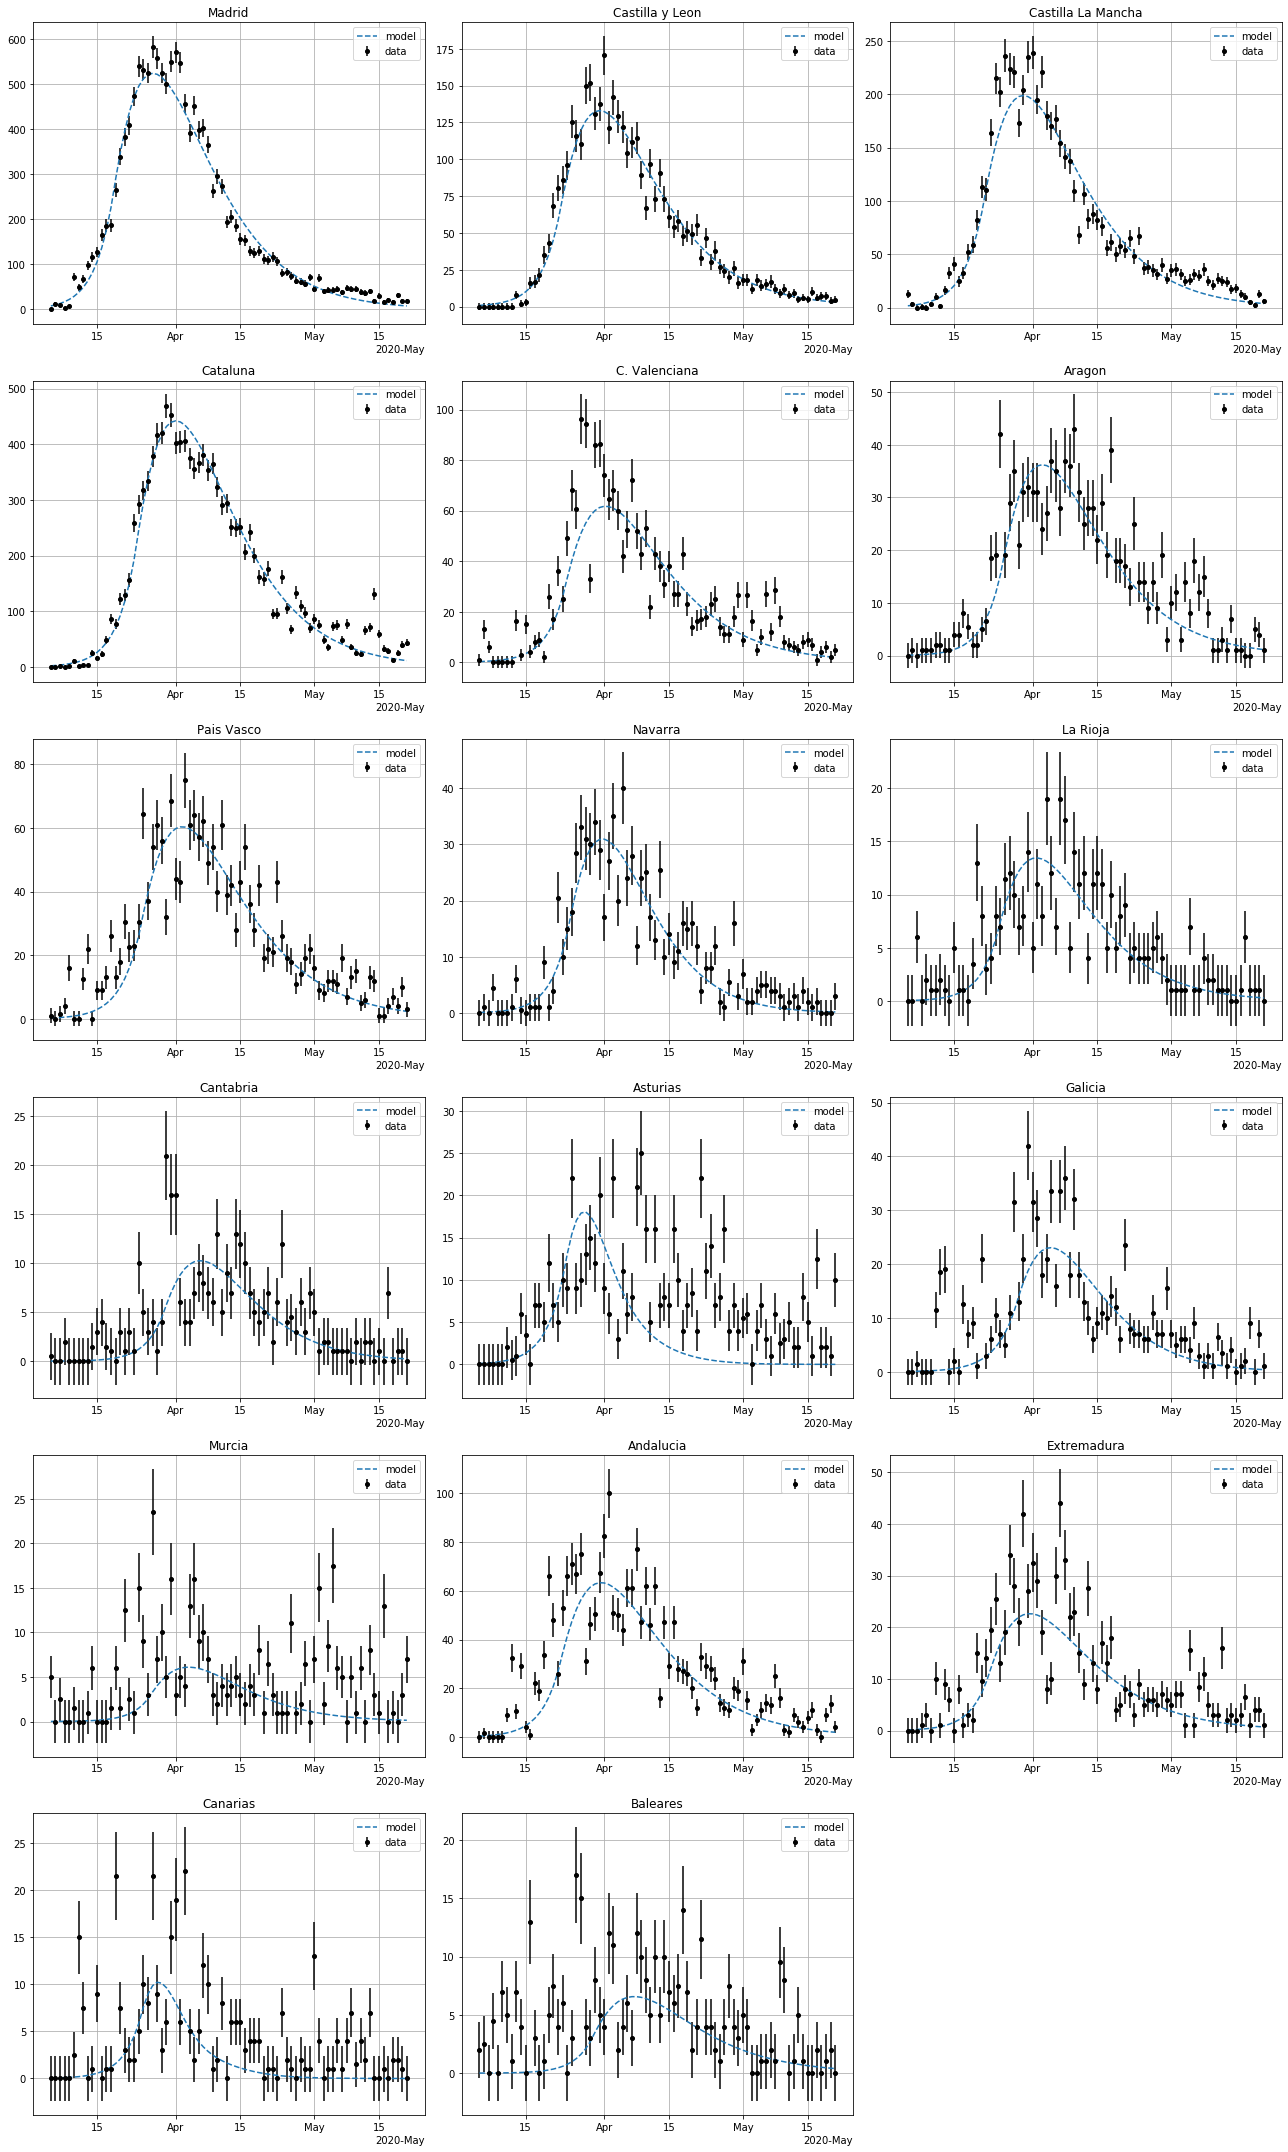

In [81]:
masks   = (('t0', 'tr'), ('s1', 'beta'), ('phi', 'gamma'))
capars2, cachi22 = ana_capars(masks, canames = canames, capars = capars1, 
                              fit = True, ofilename = 'capars1.txt')

IntProgress(value=0, description='Madrid', max=3)

IntProgress(value=0, description='Castilla y Leon', max=3)

IntProgress(value=0, description='Castilla La Mancha', max=3)

IntProgress(value=0, description='Cataluna', max=3)

IntProgress(value=0, description='C. Valenciana', max=3)

IntProgress(value=0, description='Aragon', max=3)

IntProgress(value=0, description='Pais Vasco', max=3)

IntProgress(value=0, description='Navarra', max=3)

IntProgress(value=0, description='La Rioja', max=3)

IntProgress(value=0, description='Cantabria', max=3)

IntProgress(value=0, description='Asturias', max=3)

IntProgress(value=0, description='Galicia', max=3)

IntProgress(value=0, description='Murcia', max=3)

IntProgress(value=0, description='Andalucia', max=3)

IntProgress(value=0, description='Extremadura', max=3)

IntProgress(value=0, description='Canarias', max=3)

IntProgress(value=0, description='Baleares', max=3)

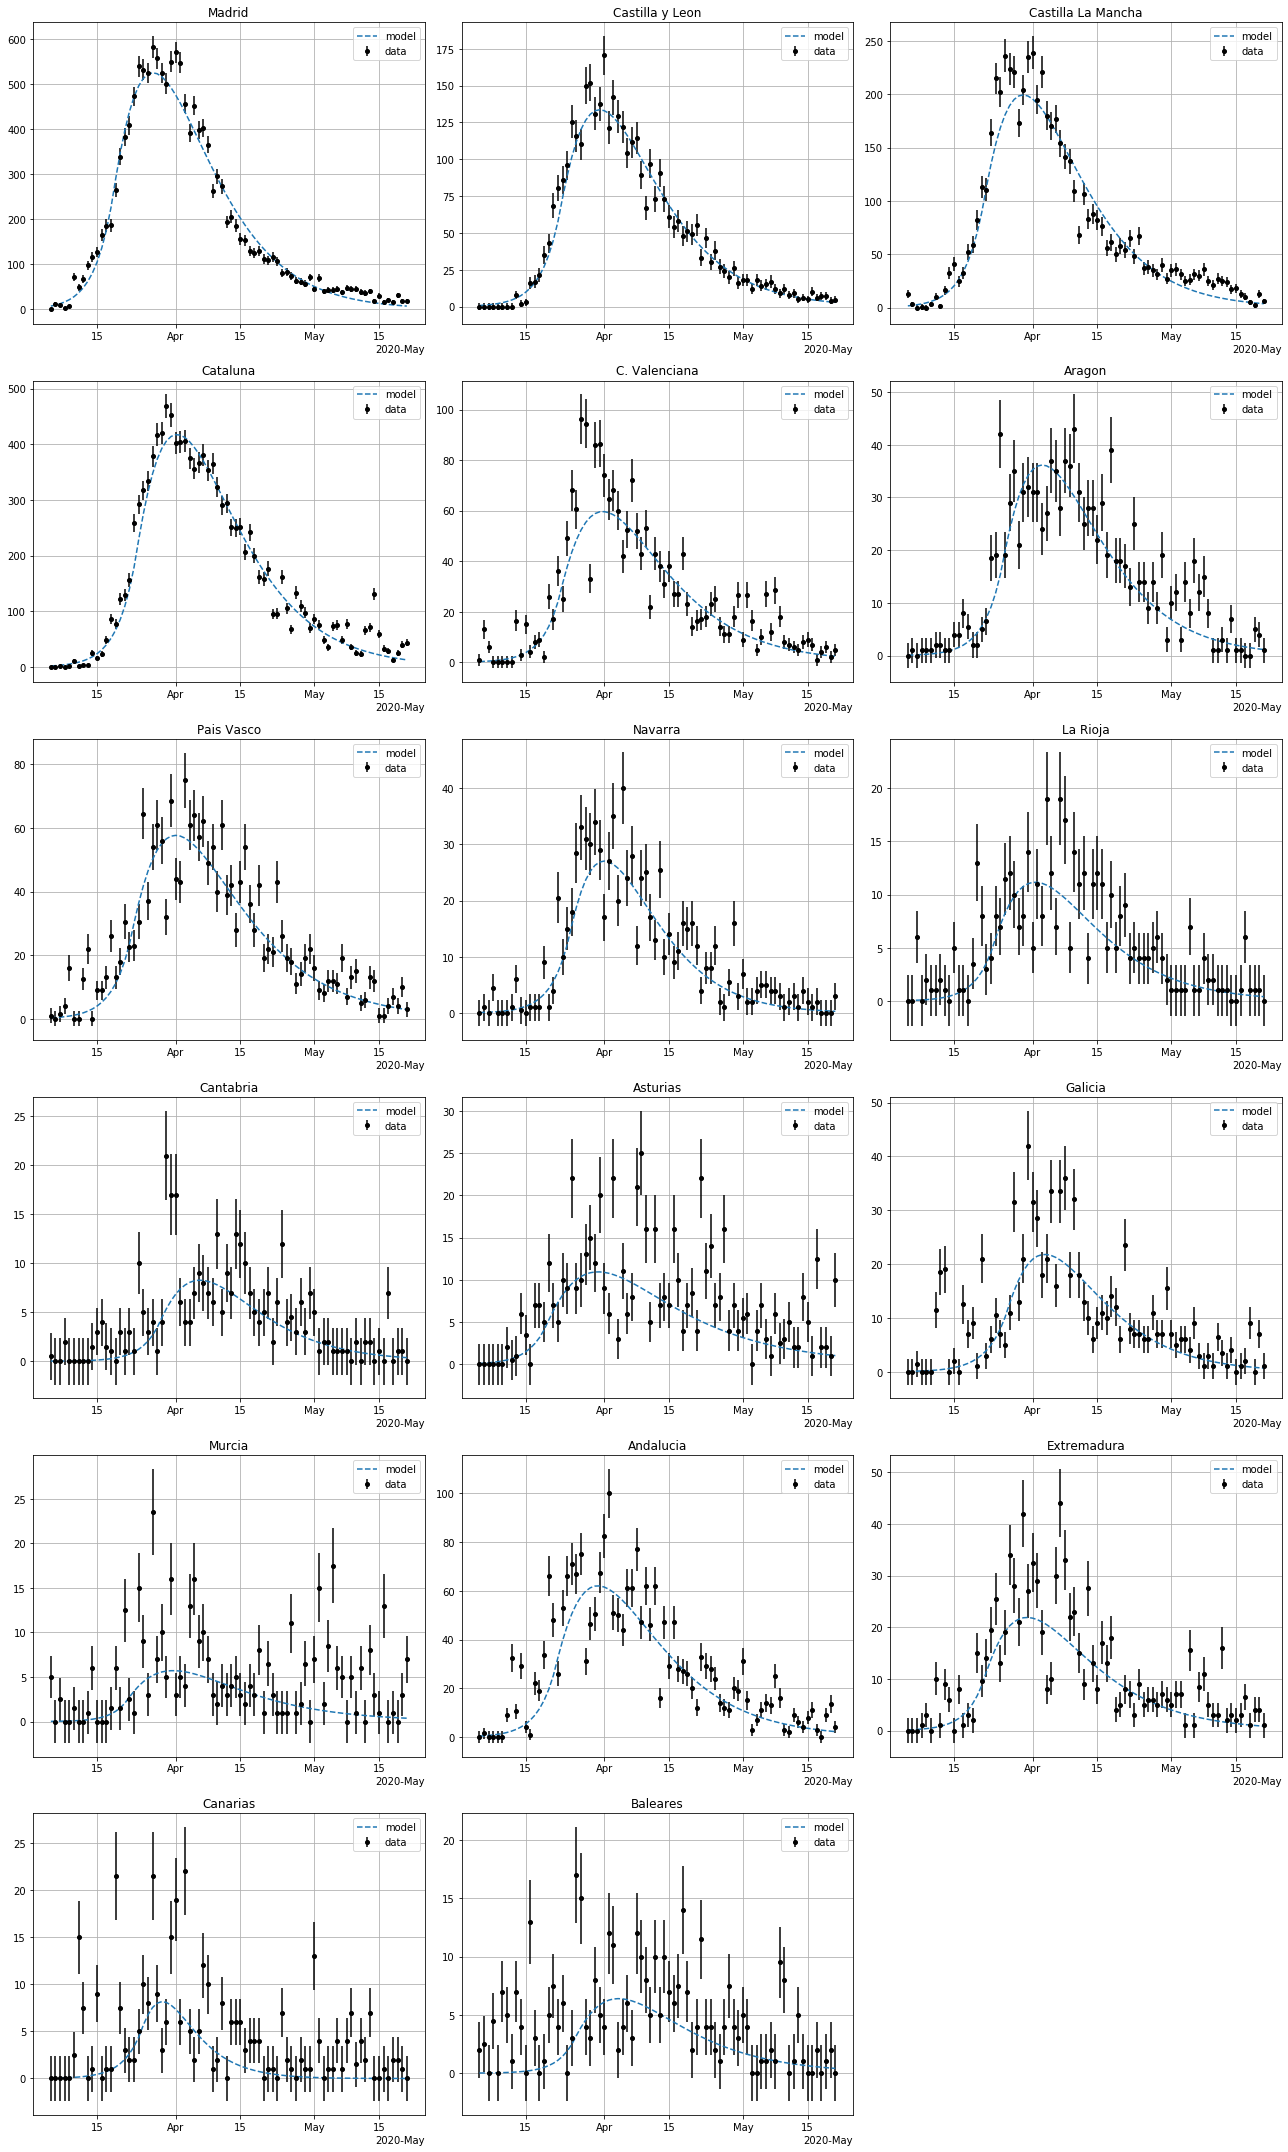

In [82]:
masks   = (('beta', 'tr', 's1'), ('gamma', 'tr', 'phi'), ('t0',))
capars3, cachi32 = ana_capars(masks, canames = canames, capars = capars2, 
                              fit = True, ofilename = 'capars2.txt')

In [78]:
capars3, cachi23

({'Madrid': {'t0': 41.337178058807396,
   'beta': 2.056455539148531,
   'gamma': 0.23195672973982434,
   'tr': 2.0915579833242206,
   'ti': 5.5,
   'tm': 10.0,
   'n': 6578079.0,
   'phi': 0.008192580498532866,
   's1': 0.13187670071253066},
  'Cataluna': {'t0': 37.21370233836275,
   'beta': 1.8930768031424505,
   'gamma': 0.21604050798780694,
   'tr': 2.2675931380497905,
   'ti': 5.5,
   'tm': 10.0,
   'n': 7600065.0,
   'phi': 0.007778268003709921,
   's1': 0.0952234204432649}},
 {'Madrid': 6.387937882970191, 'Cataluna': 9.25297380273259})

IntProgress(value=0, description='Madrid', max=2)

mle: warning


IntProgress(value=0, description='Cataluna', max=2)

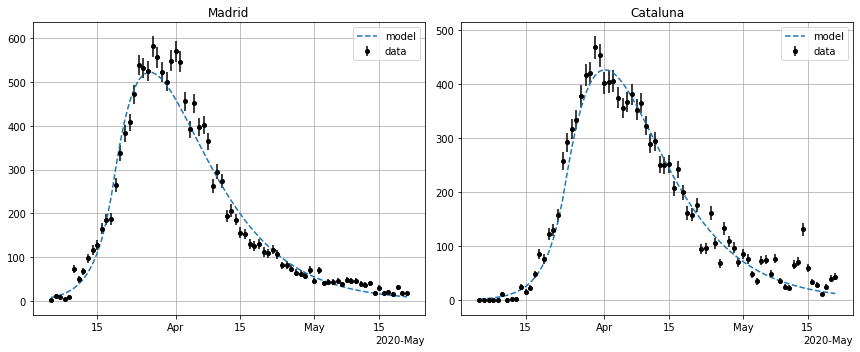

In [65]:
masks   = (('t0', 'phi', 's1'), ('beta', 'gamma', 'tr'))
canames1 = ['Madrid', 'Cataluna']
capars3, cachi23 = ana_capars(masks, canames = canames1, capars = capars2, 
                              fit = True, ofilename = 'temp.txt')

In [180]:
import ipywidgets as widgets
from ipywidgets import IntProgress
from IPython.display import display
import time



Help on function display in module IPython.core.display:

display(*objs, include=None, exclude=None, metadata=None, transient=None, display_id=None, **kwargs)
    Display a Python object in all frontends.
    
    By default all representations will be computed and sent to the frontends.
    Frontends can decide which representation is used and how.
    
    In terminal IPython this will be similar to using :func:`print`, for use in richer
    frontends see Jupyter notebook examples with rich display logic.
    
    Parameters
    ----------
    objs : tuple of objects
        The Python objects to display.
    raw : bool, optional
        Are the objects to be displayed already mimetype-keyed dicts of raw display data,
        or Python objects that need to be formatted before display? [default: False]
    include : list, tuple or set, optional
        A list of format type strings (MIME types) to include in the
        format data dict. If this is set *only* the format types included

0

AttributeError: 'function' object has no attribute 'clear'

In [146]:
capars3

NameError: name 'capars3' is not defined

### --- Definition of pars0

total  14661.0 , % populatÇion - s1  0.2785957724131924


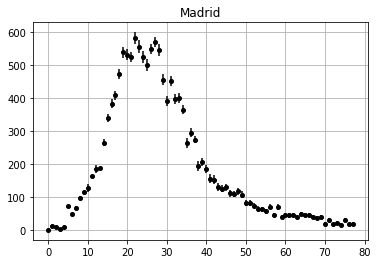

In [109]:
caname = 'Madrid'
dates, cases, ucases = ca_cases(caname)
ts                   = np.arange(len(dates))

xdata  = ts, cases

n0, phim = nn['Madrid'], 0.008
s1       = np.sum(cases)/ (n0 * phim)
print('total ', np.sum(cases), ', % populatÇion - s1 ', s1)

plt.errorbar(ts, cases, yerr = ucases, ls = '', marker = 'o', ms = 4, color = 'black')
plt.title(caname); plt.grid(); #c19ma.formatter(plt.gca());

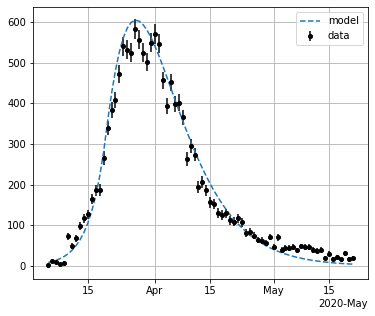

In [110]:
import c19.useir_ana as usa

n0 = nn['Madrid']

kpars =  {'t0': 42.0, 'beta': 2., 'gamma': 0.18, 'tr': 2., 'ti': 5.5, 
         'tm': 10., 'n': n0, 'phi': 0.01, 's1': 0.5 * s1}
fmodel = usa.useirq_fmodel(kpars = kpars)
usa.plot_data_model(dates, cases, fmodel)

8.298072212808181 {'t0': 42.29704575196092, 'beta': 2.0, 'gamma': 0.2, 'tr': 2.0, 'ti': 5.5, 'tm': 9.0, 'n': 6578079.0, 'phi': 0.009082260856528628, 's1': 0.16107462554086666}
6.936895071739105 {'t0': 42.29704575196092, 'beta': 1.9955919543032645, 'gamma': 0.2271214331513547, 'tr': 2.0, 'ti': 5.5, 'tm': 9.0, 'n': 6578079.0, 'phi': 0.009082260856528628, 's1': 0.16107462554086666}
6.800900628676569 {'t0': 42.60017952422183, 'beta': 1.9955919543032645, 'gamma': 0.2271214331513547, 'tr': 2.0, 'ti': 5.5, 'tm': 9.0, 'n': 6578079.0, 'phi': 0.008798505993225146, 's1': 0.15581004721992825}
6.555374388836003 {'t0': 42.60017952422183, 'beta': 1.9843548111819103, 'gamma': 0.2389030668262233, 'tr': 2.010452569747075, 'ti': 5.5, 'tm': 9.0, 'n': 6578079.0, 'phi': 0.008798505993225146, 's1': 0.15581004721992825}


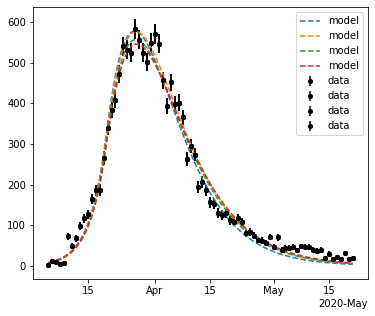

In [111]:
kpars =  {'t0': 42.0, 'beta': 2., 'gamma': 0.2, 'tr': 2., 'ti': 5.5, 
         'tm': 9., 'n': n0, 'phi': 0.015, 's1': 0.5 * s1}
#kpars =  {'t0': 39.0, 'beta': 1.78, 'gamma': 0.40, 'tr': 1.9, 'ti': 5.5, 
#         'tm': 1.9, 'n': 3000000.0, 'phi': 0.016, 's1': 0.0354}
masks = (('t0', 'phi', 's1'), ('beta', 'gamma'), ('t0', 'phi', 's1'), ('beta', 'gamma', 'tr'))
for imask in masks:
    kpars, chi2 = usa.useirqm_chi2fit(dates, cases, kpars = kpars, kmask = imask)
    fmodel      = usa.useirqm_fmodel(kpars = kpars)
    usa.plot_data_model(dates, cases, fmodel)
    print(chi2, kpars)

total  3757.5 , % population - s1  0.1559669661343105


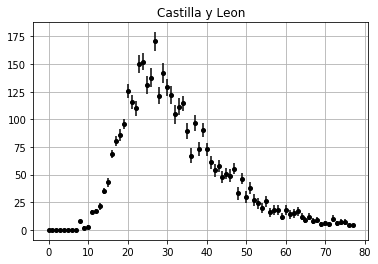

In [80]:
caname = 'Castilla y Leon'
dates, cases, ucases = ca_cases(caname)
ts                   = np.arange(len(dates))

xdata  = ts, cases

n0, phim = nn['Castilla y Leon'], 0.01
s1       = np.sum(cases)/ (n0 * phim)
print('total ', np.sum(cases), ', % population - s1 ', s1)

plt.errorbar(ts, cases, yerr = ucases, ls = '', marker = 'o', ms = 4, color = 'black')
plt.title(caname); plt.grid(); #c19ma.formatter(plt.gca());

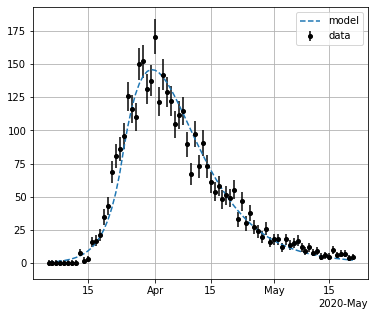

In [106]:
kpars =  {'t0': 35.0, 'beta': 2., 'gamma': 0.18, 'tr': 2., 'ti': 5.5, 
         'tm': 10., 'n': n0, 'phi': 0.010, 's1': 0.8 * s1}
kpars = {'t0': 32.628202681415445, 'beta': 1.1784669301281951, 'gamma': 0.0440684155209541, 'tr': 9.131583436722604, 'ti': 5.5, 'tm': 9.0, 'n': 2409164.0, 'phi': 0.006786888204621562, 's1': 0.12980858631827444}
kpars = {'t0': 33.80409138072298, 'beta': 1.9585138262342427, 'gamma': 0.20806571045940012, 'tr': 2.008473313428096, 'ti': 5.5, 'tm': 9.0, 'n': 2409164.0, 'phi': 0.009362884656686186, 's1': 0.10806856759234126}
fmodel = usa.useirq_fmodel(kpars = kpars)
usa.plot_data_model(dates, cases, fmodel)

6.551771368003652 {'t0': 41.125, 'beta': 1.3333333333333333, 'gamma': 0.13333333333333333, 'tr': 3.0, 'ti': 5.5, 'tm': 9.0, 'n': 2409164.0, 'phi': 0.01, 's1': 0.10917687629401734}
4.316975168829468 {'t0': 41.125, 'beta': 1.3333333333333333, 'gamma': 0.13333333333333333, 'tr': 3.0, 'ti': 5.5, 'tm': 9.0, 'n': 2409164.0, 'phi': 0.01, 's1': 0.10371803247931648}
4.030438280696348 {'t0': 41.125, 'beta': 1.3296139597200887, 'gamma': 0.14820591187360482, 'tr': 3.0, 'ti': 5.5, 'tm': 9.0, 'n': 2409164.0, 'phi': 0.01, 's1': 0.10371803247931648}
3.839628218152674 {'t0': 41.4774710159021, 'beta': 1.3296139597200887, 'gamma': 0.14820591187360482, 'tr': 3.0, 'ti': 5.5, 'tm': 9.0, 'n': 2409164.0, 'phi': 0.009357775749646725, 's1': 0.10053594083307879}
3.2113138009261966 {'t0': 41.4774710159021, 'beta': 0.828870607206962, 'gamma': 0.03887957964322965, 'tr': 9.514813233676428, 'ti': 5.5, 'tm': 9.0, 'n': 2409164.0, 'phi': 0.009357775749646725, 's1': 0.10053594083307879}


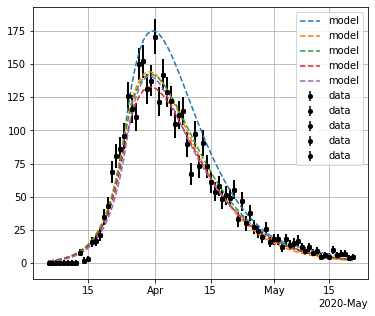

In [107]:
TR = 3
fi = TR/2.
kpars =  {'t0': 35.0, 'beta': 2./fi, 'gamma': 0.2/fi, 'tr': 2. * fi, 'ti': 5.5, 
         'tm': 9., 'n': n0, 'phi': 0.010, 's1': 0.7 * s1}
#kpars =  {'t0': 39.0, 'beta': 1.78, 'gamma': 0.40, 'tr': 1.9, 'ti': 5.5, 
#         'tm': 1.9, 'n': 3000000.0, 'phi': 0.016, 's1': 0.0354}
masks = (('t0',), ('s1',), ('beta', 'gamma'), ('t0', 'phi', 's1'), ('beta', 'gamma', 'tr'))
for imask in masks:
    kpars, chi2 = usa.useirqm_chi2fit(dates, cases, kpars = kpars, kmask = imask)
    fmodel      = usa.useirqm_fmodel(kpars = kpars)
    usa.plot_data_model(dates, cases, fmodel)
    print(chi2, kpars)

11.45671693621479 {'t0': 50.39999999999998, 'beta': 1.3333333333333333, 'gamma': 0.12, 'tr': 3.0, 'ti': 5.5, 'tm': 10.0, 'n': 6578079.0, 'phi': 0.01, 's1': 0.12885054474110152}
8.67826047064083 {'t0': 50.39999999999998, 'beta': 1.3629132617536603, 'gamma': 0.15218073112814462, 'tr': 3.0, 'ti': 5.5, 'tm': 10.0, 'n': 6578079.0, 'phi': 0.01, 's1': 0.12885054474110152}
8.67826047064083 {'t0': 50.39999999999998, 'beta': 1.3629132617536603, 'gamma': 0.15218073112814462, 'tr': 3.0, 'ti': 5.5, 'tm': 10.0, 'n': 6578079.0, 'phi': 0.01, 's1': 0.12885054474110152}
8.67826047064083 {'t0': 50.39999999999998, 'beta': 1.3629132617536603, 'gamma': 0.15218073112814462, 'tr': 3.0, 'ti': 5.5, 'tm': 10.0, 'n': 6578079.0, 'phi': 0.01, 's1': 0.12885054474110152}


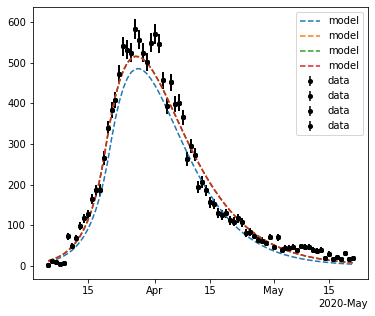

In [64]:
TR = 3.
fi = 3/2.
kpars =  {'t0': 42.0, 'beta': 2./fi, 'gamma': 0.18/fi, 'tr': TR, 'ti': 5.5, 
         'tm': 10., 'n': n0, 'phi': 0.01, 's1': 0.5 * s1}
#kpars =  {'t0': 39.0, 'beta': 1.78, 'gamma': 0.40, 'tr': 1.9, 'ti': 5.5, 
#         'tm': 1.9, 'n': 3000000.0, 'phi': 0.016, 's1': 0.0354}
masks = 2*(('t0', 's1'), ('beta', 'gamma'))
for imask in masks:
    kpars, chi2 = usa.useirqm_chi2fit(dates, cases, kpars = kpars, kmask = imask)
    fmodel      = usa.useirqm_fmodel(kpars = kpars)
    usa.plot_data_model(dates, cases, fmodel)
    print(chi2, kpars)

26.71085209557636 {'t0': 43.575, 'beta': 1.3333333333333333, 'gamma': 0.13333333333333333, 'tr': 5.0, 'ti': 5.5, 'tm': 10.0, 'n': 6578079.0, 'phi': 0.01, 's1': 0.12885054474110144}
9.111784334999024 {'t0': 43.575, 'beta': 1.3331942009215716, 'gamma': 0.10240643200726443, 'tr': 5.0, 'ti': 5.5, 'tm': 10.0, 'n': 6578079.0, 'phi': 0.01, 's1': 0.12885054474110144}
7.475043429130874 {'t0': 42.48562500000001, 'beta': 1.3331942009215716, 'gamma': 0.10240643200726443, 'tr': 5.0, 'ti': 5.5, 'tm': 10.0, 'n': 6578079.0, 'phi': 0.01, 's1': 0.13368244016889275}
6.537187252297472 {'t0': 42.48562500000001, 'beta': 1.3452508119207176, 'gamma': 0.09186792004807656, 'tr': 5.0, 'ti': 5.5, 'tm': 10.0, 'n': 6578079.0, 'phi': 0.01, 's1': 0.13368244016889275}


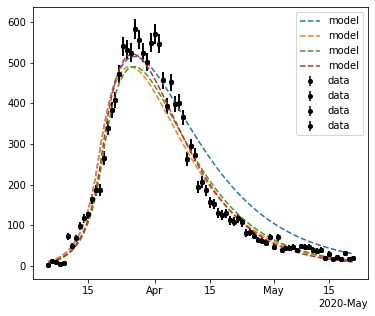

In [65]:
TR = 5.
fi = 3/2.
kpars =  {'t0': 42.0, 'beta': 2./fi, 'gamma': 0.2/fi, 'tr': TR, 'ti': 5.5, 
         'tm': 10., 'n': n0, 'phi': 0.01, 's1': 0.5 * s1}
#kpars =  {'t0': 39.0, 'beta': 1.78, 'gamma': 0.40, 'tr': 1.9, 'ti': 5.5, 
#         'tm': 1.9, 'n': 3000000.0, 'phi': 0.016, 's1': 0.0354}
masks = 2*(('t0', 's1'), ('beta', 'gamma'))
for imask in masks:
    kpars, chi2 = usa.useirqm_chi2fit(dates, cases, kpars = kpars, kmask = imask)
    fmodel      = usa.useirqm_fmodel(kpars = kpars)
    usa.plot_data_model(dates, cases, fmodel)
    print(chi2, kpars)

### uSEIR-quenched with t0

total  14033
mle: warning


{'t0': 27.22771502086421,
 'beta': 3.9743340412221855,
 'gamma': 0.38892460605675927,
 'tr': 1.574824890950996,
 'ti': 5.5,
 'tm': 9.8,
 'n': 3000000.0,
 'phi': 0.014189043705958852,
 's1': 0.23457388898251244}

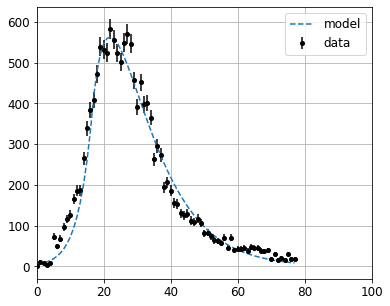

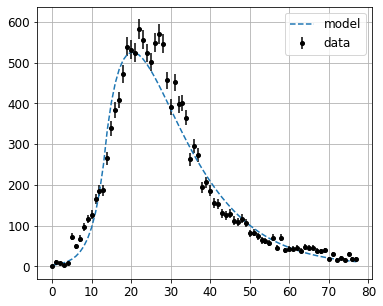

In [310]:
ufun = lambda pars : us._t0(pars, us._useirvarext)

pars = getpars(t0 = 35, beta = 1.8, gamma = 0.1, s1 = 0.20, tr = 3.)
times, xmcdata = us.rvs(pars, ufun = ufun)

xmcs, ymcs = xmcdata
print('total ', np.sum(ymcs))

#usa.plot_fit_data(xmcdata, pars, ufun= ufun)
usa.plot_fit_data(xdata, pars, ufun= ufun)
plt.xlim((0, 100));

kpars = {'t0': 35, 'beta' : 1.8, 'gamma' : 0.1, 's1' : 0.20, 'tr' : 5.}
ana_ca('Madrid', kpars = kpars)

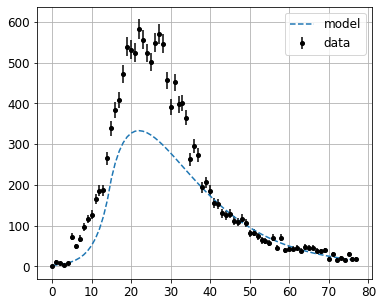

In [287]:
usa.plot_fit_data(xdata, pars, ufun= ufun)

In [127]:
def fit(fun, pars, mask = None, method = 'Delder-Mead'):
    res = cfit.minimize(pars, fun, mask = mask, method = method)

In [240]:
kmask0 = (('t0', 'phi', 's1'), ('beta', 'gamma', 'tr'))

def ana_ca(caname, kpars = {}, kmasks = kmask0, ax = None): 
    for i, kmask in enumerate(kmasks):
        ok = i == len(kmasks) - 1
        kpars = ana_ca_fit(caname, kpars, kmask, plot = ok, ax = ax)
        #print('mask: ', kmask)
        #print('pars: ', kpars)
    return kpars
    #kmask  = ('ti', 'tm')

def ana_ca_fit(caname, kpars, kmask, plot = True, ax = None):
    dates, cases, ucases = ca_cases(caname)
    ts                   = np.arange(len(dates))
    xdata  = ts, cases

    ufun = lambda pars : us._t0(pars, us._useirvarext)
    fun    = us.res(xdata, ufun = ufun)

    return ana_fit(xdata, fun, kpars, kmask, ufun, plot = plot, ax = ax)

def ana_fit(xdata, fun, kpars, kmask, ufun, plot, ax = None):
    xpars = getpars(**kpars)
    xmask = getmask(kmask)
    res   = cfit.minimize(xpars, fun, mask = xmask, method = 'Nelder-Mead')
    #print('initial pars   ', getparsdir(xpars))
    #print('estimated pars ', getparsdir(res))
    #print('initial guess  ', kmask, xpars[xmask])
    #print('estimated pars ', kmask, res[xmask])
    #print('fun value ', np.sum(fun(res)), ', initial ', np.sum(fun(xpars)))
    #usa.plot_fit_data(xdata, xpars, ufun = ufun)
    if (plot):
        usa.plot_fit_data(xdata, res  , ufun = ufun, ax = ax)
    return getparsdir(res)

### testing different parameters

{'t0': 43.0,
 'beta': 1.718595332557614,
 'gamma': 0.2,
 'tr': 3.6089703829738884,
 'ti': 5.5,
 'tm': 7.0,
 'n': 3000000.0,
 'phi': 0.016,
 's1': 0.11}

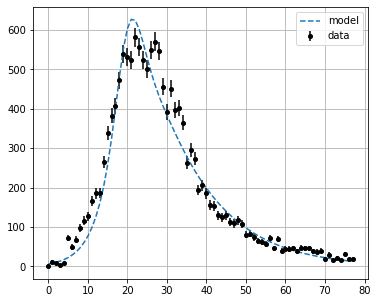

In [216]:
kpars = {'beta': 2., 'tr': 3}
kmask = ('beta', 'tr')
ana_ca_fit('Madrid', kpars, kmask)

/Users/hernando/investigacion/bio/c19/c19/useir.py:35: RuntimeWarning: invalid value encountered in true_divide
  return lambda x: xp(x)/norma


{'t0': 53.222073955726486,
 'beta': 5.0,
 'gamma': 0.6299999999999992,
 'tr': 1.0,
 'ti': 5.5,
 'tm': 7.0,
 'n': 3000000.0,
 'phi': 0.027425916590367236,
 's1': 0.10241697133106084}

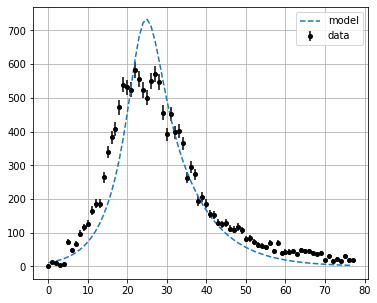

In [259]:
r0, r1 = 5., 0.6
kpars = {'t0': 41.4, 'beta': r0/1., 'gamma': r1/1., 'tr': 1., 'n': 3e6, 'phi': 0.017, 's1': 0.12}
ana_ca('Madrid', kpars)

/Users/hernando/investigacion/bio/c19/c19/useir.py:35: RuntimeWarning: invalid value encountered in true_divide
  return lambda x: xp(x)/norma


{'t0': 42.294665306931556,
 'beta': 3.1172733948929716,
 'gamma': 0.4724109490713252,
 'tr': 1.0000030726213893,
 'ti': 5.5,
 'tm': 7.0,
 'n': 3000000.0,
 'phi': 0.016343152249815758,
 's1': 0.12574220285724708}

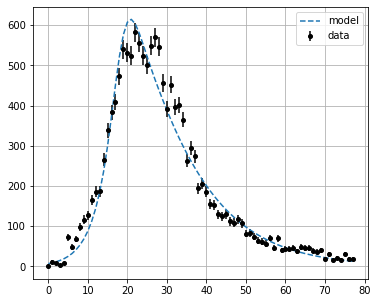

In [260]:
kpars = {'t0': 41.4, 'beta': r0/2., 'gamma': r1/2., 'tr': 2., 'n': 3e6, 'phi': 0.017, 's1': 0.12}
ana_ca('Madrid', kpars)

{'t0': 47.3849543239091,
 'beta': 1.5199098793006631,
 'gamma': 0.19653788284534918,
 'tr': 3.4089234384963816,
 'ti': 5.5,
 'tm': 7.0,
 'n': 3000000.0,
 'phi': 0.01867477732164819,
 's1': 0.11363539328832636}

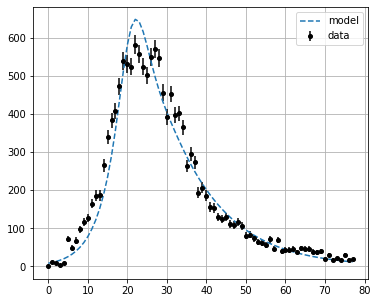

In [261]:
kpars = {'t0': 41.4, 'beta': r0/3., 'gamma': r1/3., 'tr': 3., 'n': 3e6, 'phi': 0.017, 's1': 0.12}
ana_ca('Madrid', kpars)

{'t0': 50.18113117426208,
 'beta': 1.509174965775129,
 'gamma': 0.22031496222402633,
 'tr': 3.041330757205394,
 'ti': 5.5,
 'tm': 7.0,
 'n': 3000000.0,
 'phi': 0.019259651622391908,
 's1': 0.11836763573792294}

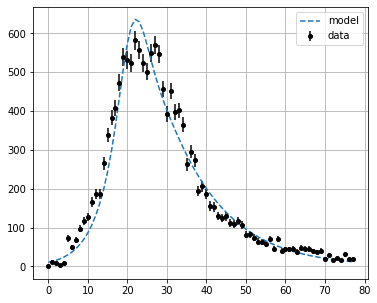

In [262]:
kpars = {'t0': 41.4, 'beta': r0/4., 'gamma': r1/4., 'tr': 4., 'n': 3e6, 'phi': 0.017, 's1': 0.12}
ana_ca('Madrid', kpars)

{'t0': 52.048004431558816,
 'beta': 1.616828818285906,
 'gamma': 0.25912617042779285,
 'tr': 2.375385977715603,
 'ti': 5.5,
 'tm': 7.0,
 'n': 3000000.0,
 'phi': 0.025160068610011188,
 's1': 0.08495774784597696}

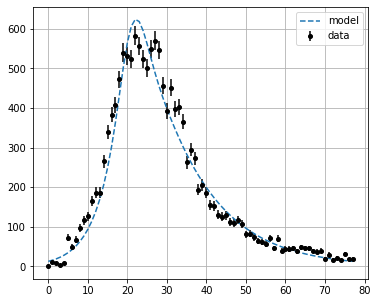

In [263]:
kpars = {'t0': 41.4, 'beta': r0/5., 'gamma': r1/5., 'tr': 5., 'n': 3e6, 'phi': 0.017, 's1': 0.12}
ana_ca('Madrid', kpars)

{'t0': 41.37497582339802,
 'beta': 2.568234674181266,
 'gamma': 0.3361491329278037,
 'tr': 1.910693044862603,
 'ti': 5.5,
 'tm': 7.0,
 'n': 3000000.0,
 'phi': 0.01747617800739982,
 's1': 0.11906264340434865}

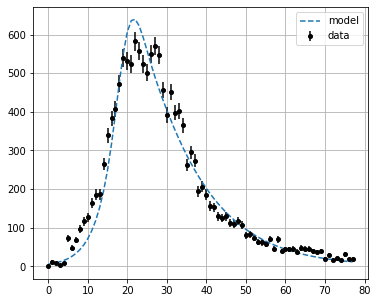

In [217]:
ana_ca('Madrid')

/Users/hernando/investigacion/bio/c19/c19/useir.py:35: RuntimeWarning: invalid value encountered in true_divide
  return lambda x: xp(x)/norma
/Users/hernando/investigacion/bio/c19/c19/useir.py:35: RuntimeWarning: invalid value encountered in true_divide
  return lambda x: xp(x)/norma


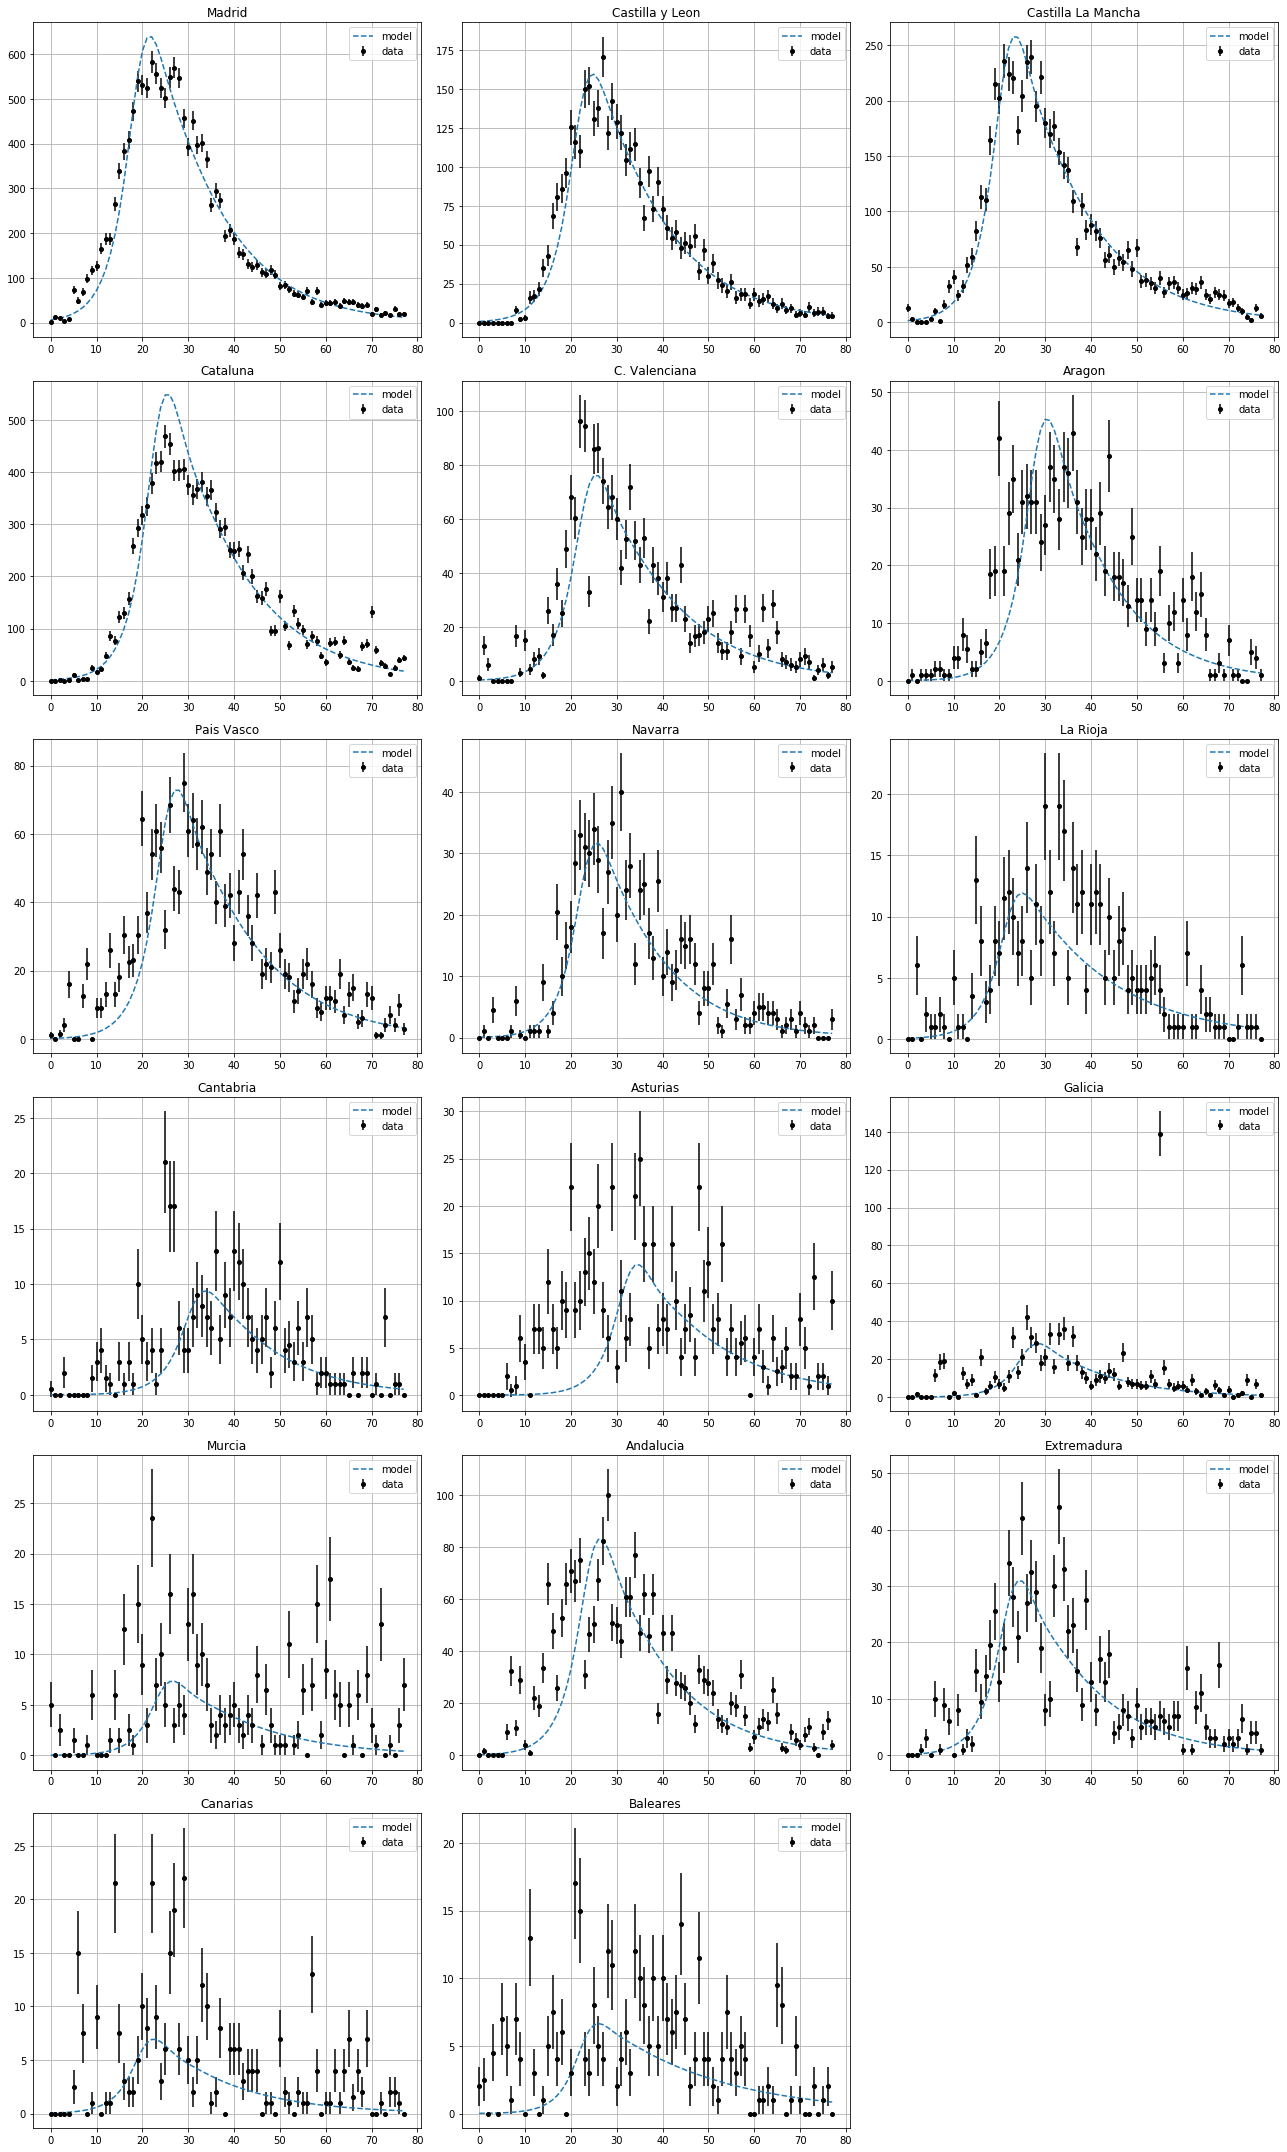

In [221]:
canames = ['Madrid', 'Castilla y Leon', 'Castilla La Mancha',
           'Cataluna', 'C. Valenciana', 'Aragon',
           'Pais Vasco', 'Navarra', 'La Rioja',
           'Cantabria', 'Asturias', 'Galicia',
           'Murcia', 'Andalucia', 'Extremadura',
           'Canarias', 'Baleares']

ncols, nrows = 3, 6
plt.figure(figsize = (ncols * 6, nrows * 5))

blind = False
capars = {}
for i, caname in enumerate(canames):
    ax = plt.subplot(nrows, ncols, i + 1, axisbelow=True)
    pars = ana_ca(caname, ax = ax)
    capars[caname] = pars
    plt.title(caname)
plt.tight_layout()

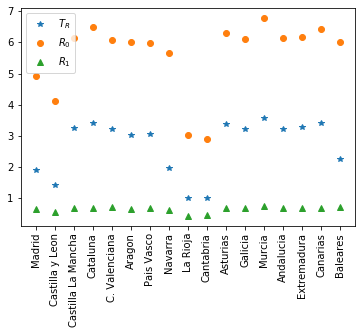

In [235]:
trs    = npa([capars[caname]['tr'] for caname in canames])
betas  = npa([capars[caname]['beta'] for caname in canames])
gammas = npa([capars[caname]['gamma'] for caname in canames])
plt.plot(trs, ls = '', marker = '*', label = r'$T_R$');
plt.plot(trs * betas, ls = '', marker = 'o', label = r'$R_0$');
plt.plot(trs * gammas, ls = '', marker = '^', label = r'$R_1$');
plt.legend();
plt.xticks(np.arange(len(canames)), canames, rotation = 90);

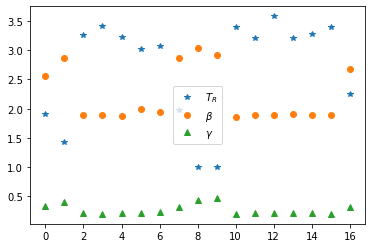

In [227]:
trs    = npa([capars[caname]['tr'] for caname in canames])
betas  = npa([capars[caname]['beta'] for caname in canames])
gammas = npa([capars[caname]['gamma'] for caname in canames])
plt.plot(trs, ls = '', marker = '*', label = r'$T_R$');
plt.plot(betas, ls = '', marker = 'o', label = r'$\beta$');
plt.plot(gammas, ls = '', marker = '^', label = r'$\gamma$');
plt.legend();

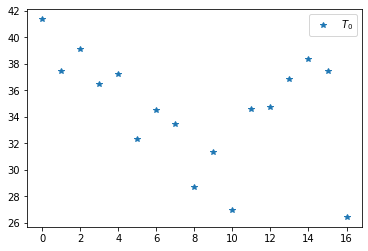

In [229]:
t0s = npa([capars[caname]['t0'] for caname in canames])
phis  = npa([capars[caname]['phi'] for caname in canames])
s1s = npa([capars[caname]['s1'] for caname in canames])
plt.plot(t0s, ls = '', marker = '*', label = r'$T_0$');
#plt.plot(betas, ls = '', marker = 'o', label = r'$\beta$');
#plt.plot(gammas, ls = '', marker = '^', label = r'$\gamma$');
plt.legend();

In [ ]:
t0s = npa([capars[caname]['t0'] for caname in canames])
plt.plot(t0s, ls = '', marker = '*', label = r'$T_0$');
plt.legend();

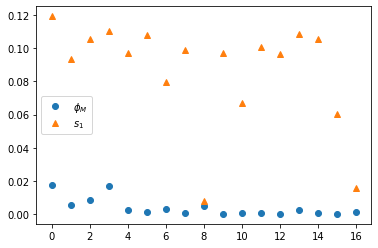

In [230]:
plt.plot(phis, ls = '', marker = 'o', label = r'$\phi_M$');
plt.plot(s1s, ls = '', marker = '^', label = r'$s_1$');
plt.legend();